# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# Neighborhood reconstruction from pseudocells

##### Ver:: A1_V1
##### Author(s) : Issac Goh
##### Date : 231002;YYMMDD
### Author notes
- This set of modules first computes a series of learnt attention scores for each cell given a graph input
- These attention scores are then used to sample the data
- The aim of this sampling is to get a good representation of the data given prior knowledge provided from the graph
- We can then construct pseudocells using these sampled data points and the original graph
    
### Features to add
- Add ability to consume anndata zar format for sequential learning
### Modes to run in
- stratified
- unstratified

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl
import matplotlib.pyplot as plt


#¢ new modules
import psutil
import time
import threading
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty
import scipy

Make sure that Python modules winreg, win32api or win32con are installed.
INFO: blas_opt_info:
INFO: blas_armpl_info:
INFO: customize UnixCCompiler
INFO:   libraries armpl_lp64_mp not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blas_mkl_info:
INFO:   libraries mkl_rt not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blis_info:
INFO:   libraries blis not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: openblas_info:
INFO:   libraries openblas not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: accelerate_info:
INFO:   NOT AVAILABLE
I

In [2]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
'int_atlas_sub':'/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/example_notebooks/Simple_sampled_adata_V1.h5ad',
'int_atlas_full':'/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad',
}

#setup global params:
# Variable assignment
train_model = True
adata_key = 'YS_local'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'new_example_model'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'LVL3'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False # should data be normalised?

# setup model parameters:
model_params = {
'feat_use': 'LVL3',
'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
    
# Stratified Bayes sampler kwargs
'sample_data_knn':True,
'straify_sampling':False,
'knn_key' : 'neighbors',
'sampling_rate': 0.1,# Apply empirical bayes sampling weighted by knn?
'weight_penalty': 'laplacian_SGD_pagerank', # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
'iterations': 10,#How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
'representation_priority': 0.7, # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
'replace': True, # Allows model to clone cells
'equal_allocation': False, # Forces model to create equal representation sets
'resample_clones':True,
'pl_label_entropy':False,
    
# Params for STGD-pagerank
'num_iterations': 1000,# How many mini-batches to learn
'mini_batch_size': 1000,# How large should each mini-batch be
'full_batch_update_iters': 100, # How many full batch updates
}

# Transductive workflow
- First we train a model on a subset of our data which we will then later use to generalise across our dataset.

- We sample our data using a set of empirical priors based on the known distribution of celltype labels, we then consider a weight to represent the liklihood of sampling by taking the sum of weights for each vertice sharing labels divided by vertices that have different labels. 

# Bayesian_balanced_stratified_sampling
This function, bayesian_balanced_stratified_sampling, performs stratified sampling on single-cell data stored in an AnnData object. It uses empirical Bayesian updating to balance the representation of each cell type (label) in the data. The sampling process considers the neighborhood relationships between cells, which helps maintain the local structure of the original data.

The sampling can be adjusted with several options, including:

equal_allocation: If enabled, each label gets an equal share of the total sample size. Otherwise, the sample size for each label is proportional to its prior probability.
replace: If enabled, sampling is done with replacement, allowing the model to create clones of cells.
iterations: Determines the number of times the sampling process is repeated, updating the label probabilities in each iteration.
The output is a new AnnData object containing the sampled cells and the indices of the sampled cells.

If left as default, underepresented states will naturally be prioritised in sampling as iterations increases, thus if you are experiencing issues with under representation, increase iterations. 

- Representation priority represents a wighting factor used to recover rare-states. 
- Prioritisation factor, this will heavily bias the sampling of under-represented states

# Using stratified sampling module with clones
- This module provides different attention metrics for local/global node importance measures
- Uses the prior distribution of cell-states as a prior for the sampling module
- Able to dynamically up-sample under-represented states if "replace==True"
- Penalises highly dense regions as sufficient information is available to resonctruct all relationships
- preserves the neighborhood structure so relationship to original graph is retained
- Prioritisation parameter forces the retention of known-rare states if they are subsequently removed by the sampler

# Using un-stratified sampling module
- This module provides different attention metrics for local/global node importance measures
- Uses the prior attention scores based on the established graph as priors
- Able to dybnamically up-sample under-represented states if "replace==True"
- Penalises highly dense regions as sufficient information is available to resonctruct all relationships
- preserves the neighborhood structure so relationship to original graph is retained


#### Add
- Add a module to compute minimum set for good representation

In [6]:
# setup model parameters:
model_params = {
# Stratified Bayes sampler kwargs
'sample_data_knn':True,
'straify_sampling':False, # Whether to stratify the sampling by "feat_use" or not
'knn_key' : 'neighbors',
'sampling_rate': 0.1,# Apply empirical bayes sampling weighted by knn?
'weight_penalty': 'laplacian_SGD_pagerank', # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
'iterations': 10,#How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
'representation_priority': 0.7, # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
'replace': False, # Allows model to clone cells
'equal_allocation': False, # Forces model to create equal representation sets
'resample_clones':True, # Reduce the number of clone cells where possible
'pl_label_entropy':False,
    
# Params for STGD-pagerank
'num_iterations': 1000,# How many mini-batches to learn
'mini_batch_size': 1000,# How large should each mini-batch be
'full_batch_update_iters': 200, # How many full batch updates
}

Attention-based non-straified sampling selected
Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
Converged at iteration 740
Proceeding on to perform fine-tuning across full-batch


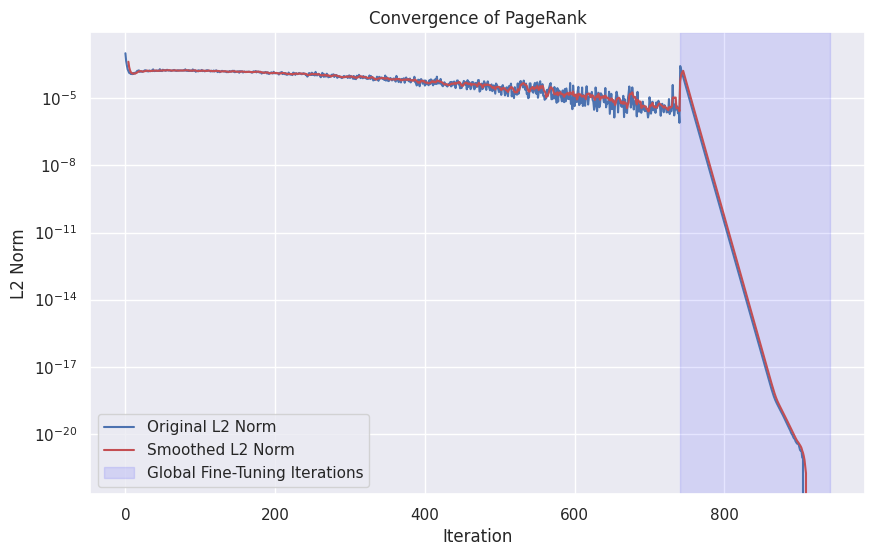

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!
adata_loaded


In [7]:
adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed='r')

if model_params['sample_data_knn'] != False:
    if model_params['straify_sampling'] == True:
        print('Empirical bayes sampling option selected')
        adata_samp, indices, weights = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, **model_params)
#         scent.plot_sampling_metrics(adata,adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
    else:
        print('Attention-based non-straified sampling selected')
        adata_samp,sample_probs, weights = scent.Attention_based_KNN_sampling(adata, **model_params)
#        scent.plot_sampling_metrics(adata,adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
print('adata_loaded')

In [9]:
import numpy as np
import scipy
import warnings
from collections import Counter

def alias_setup(probs):
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = []
    larger = []

    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]

In [10]:
from collections import Counter
knn_key = 'neighbors'
sampling_rate=0.1
iterations=1
representation_priority = 0.9
equal_allocation=False
replace = True
weight_penalty='laplacian_SGD_pagerank'
pl_label_entropy=False
resample_clones=False
kwargs = model_params
sampling_method='alias'

# Unpack kwargs
if kwargs:
    for key, value in kwargs.items():
        globals()[key] = value
    kwargs.update(locals())

print('Non-stratified sampling based on attention weights chosen')

if representation_priority > 0.8:
    print('warning: you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')
    warnings.warn('warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')

neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]
# Calculate total sample size and sample size per label for equal allocation
total_sample_size = int(sampling_rate * adata.shape[0])
#     sample_size_per_label = total_sample_size // len(unique_labels)

if weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score
    print('Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
#     # Now you can use normalized_matrix in place of neighborhood_matrix
#     attention_score = normalized_matrix[indices].sum(axis = 1)
# Convert your sparse matrix to a csr_matrix if it's not already
    csr_matrix = normalized_matrix.tocsr()
    attention_scores, l2_norm_dic = scent.SGDpagerank(csr_matrix, **kwargs) #num_iterations=1000,sampling_method='probability_based', mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, full_batch_update_iters=100,

print("proceeding to 2 stage sampling using attention scores as priors")
# Add the attention scores to the observation dataframe
adata.obs['sf_attention'] = attention_scores

# Iterate over each unique stratifying variable
# for n in adata.obs[strat_var].unique():
tmp_obs = adata.obs#[adata.obs[strat_var] == n]
indices = range(len(tmp_obs))
attention_scores_tmp = tmp_obs['sf_attention']

# Apply softmax to attention scores
e_v = np.exp(attention_scores_tmp - np.max(attention_scores_tmp))
sf_attention = e_v / e_v.sum()

# Calculate total sample size
total_sample_size = int(sampling_rate * len(tmp_obs))

# Initialize list to store all sampled indices
all_sampled_indices = []
N = 100
# Conduct sampling N times (100 by default)
if sampling_method == 'alias':
    # Prepare the Alias table
    J, q = alias_setup(sf_attention)
    # Use Alias sampling
    for _ in range(N * total_sample_size):
        all_sampled_indices.append(alias_draw(J, q))
else:  # Random sampling
    for i in range(N):
        sampled_indices = np.random.choice(indices, size=total_sample_size, replace=False, p=sf_attention)
        all_sampled_indices.extend(sampled_indices)

# Count the frequency of each index
index_freq = Counter(all_sampled_indices)

# Convert the frequencies to probabilities
total_samples = sum(index_freq.values())
sampling_probabilities = {index: freq / total_samples for index, freq in index_freq.items()}

# Convert dictionary keys and values to lists for sampling
sample_indices = list(sampling_probabilities.keys())
sample_probs = list(sampling_probabilities.values())

sampled_indices_from_output = np.random.choice(sample_indices, size=total_sample_size, p=sample_probs, replace=False)

adata_samp = adata[sampled_indices_from_output]
print("Sampling complete!")

Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank


UnboundLocalError: local variable 'mini_batch_indices' referenced before assignment

In [ ]:
# Apply softmax to attention scores
e_v = np.exp(attention_scores_tmp - np.max(attention_scores_tmp))
sf_attention = e_v / e_v.sum()

# Create the alias table
alias_table = AliasTable(sf_attention)

# Initialize list to store all sampled indices
all_sampled_indices = []

# Conduct sampling N times (100 by default)
N = 100
for i in range(N):
    sampled_indices = [alias_table.sample() for _ in range(total_sample_size)]
    all_sampled_indices.extend(sampled_indices)

# Create the alias table with your attention scores after the softmax application
alias_table = AliasTable(sf_attention)

# Now, to sample an index based on your probabilities:
index = alias_table.sample()



In [ ]:
# Create a histogram and normalize to get probabilities
hist, bins = np.histogram(sf_attention, bins=30, density=True)

# Plot the histogram of probabilities
plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor="k", alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.title("Histogram of Probabilities")
plt.show()

In [ ]:
# Create a histogram and normalize to get probabilities
hist, bins = np.histogram(sample_probs, bins=30, density=True)

# Plot the histogram of probabilities
plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor="k", alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.title("Histogram of Probabilities")
plt.show()

### Removed "feat_use" from model params to demonstrate that non-stratified sampler is independent of labels
- added back in below to show conservation of cell-states

In [ ]:
model_params['feat_use']= 'LVL3'
scent.plot_sampling_metrics(adata,adata_samp, **model_params)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(30,7))

# Plot the UMAPs on these axes
sc.pl.umap(adata, color=model_params['feat_use'], ax=axs[0], show=False)
sc.pl.umap(adata_samp, color=model_params['feat_use'], ax=axs[1], show=False)
# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Creating subplots for the histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot for sample_probs
axs[0].hist(list(sample_probs.values()), bins=10, color='blue', edgecolor='black')
axs[0].set_title('Histogram of Sampling Probs')
axs[0].set_xlabel('Probs')
axs[0].set_ylabel('Frequency')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Second subplot for weights
axs[1].hist(weights, bins=10, color='green', edgecolor='black')
axs[1].set_title('Histogram of Sampling Weights')
axs[1].set_xlabel('Weights')
axs[1].set_ylabel('Frequency')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Compare sampling bias against Randomised boostrap sampling distribution

In [ ]:
import seaborn as sns
def plot_grouped_distributions(df, plot_vars, grouping):
    # Initialize the figure
    fig_width = 12
    fig, axs = plt.subplots(len(plot_vars), 1, figsize=(fig_width, 5 * len(plot_vars)))
    
    # Make sure axs is always a list, even if plot_vars has only one item
    if len(plot_vars) == 1:
        axs = [axs]
    
    for idx, var in enumerate(plot_vars):
        sns.barplot(x=df.index, y=df[var], ax=axs[idx], color='blue')
        axs[idx].set_title(f'Distribution of {var} by {grouping}')
        axs[idx].set_xlabel(grouping)
        axs[idx].set_ylabel("log " + var)
        axs[idx].set_yscale("log")  # Set y-axis to log scale
        plt.setp(axs[idx].xaxis.get_majorticklabels(), rotation=90)
    
    plt.tight_layout()
    plt.show()
    
# test random bootstrap sompler
def compute_sampling_probability(df, grouping, sample_fraction=0.1, n_iterations=1000):
    # Step 1: Compute original proportions
    original_counts = df.groupby(grouping).size()
    original_proportions = original_counts / len(df)
    
    sampled_proportions = {group: [] for group in original_proportions.index}
    
    # Step 2: Perform Bootstrapping
    for _ in range(n_iterations):
        sampled_df = df.sample(frac=sample_fraction)
        sampled_counts = sampled_df.groupby(grouping).size()
        for group in original_proportions.index:
            sampled_proportions[group].append(sampled_counts.get(group, 0) / len(sampled_df))
    
    # Step 3: Compute sampling proportions mean
    sampling_probabilities = {group: np.mean(proportions) for group, proportions in sampled_proportions.items()}
    
    return sampling_probabilities

# Using the function with pseudo data, since I don't have the exact obs dataframe

grouping = 'LVL3'
plot_vars = ['weights','probs','bootstrap_control','SGD_PGR_output']

obs = adata.obs.copy()
# create a randomlised samping 
random_sampling_probabilities = compute_sampling_probability(obs, grouping)
# add the SGD_PGR sampled data distribution
samp_obs = adata_samp.obs.copy()
samp_obs = dict(samp_obs.groupby(grouping).size()/sum(samp_obs.groupby(grouping).size()))

obs['weights'] = weights
obs = obs.iloc[list(sample_probs.keys())]
obs['probs'] = list(sample_probs.values())
obs = obs.groupby(grouping).mean()
# add random sampling
obs['bootstrap_control'] = [random_sampling_probabilities[group] for group in obs.index]
# Add sgd_PGR sampled data
obs['SGD_PGR_output'] = [samp_obs[group] for group in obs.index]

plot_grouped_distributions(obs, plot_vars, grouping)

### Methodology for Neighborhood-Based Pseudobulk Aggregation of scRNA-seq Data

#### Update ver A0.1.2 -- 
   - Updated aggregation function to detect backed readings
   - if data is backed, assume large X partition is inevitable & create chunked reads of X for updates

#### Background:
Single-cell RNA sequencing (scRNA-seq) datasets capture diverse biological states across many cells, making it computationally challenging to analyze them directly. Pseudobulk aggregation offers a way to distill this complexity by combining data from multiple cells. This method aggregates cells based on local neighborhoods, ensuring a more biologically meaningful representation. Additionally, it incorporates a normalization step inspired by the scVI model, providing a balanced representation of each cell within its local context.

#### Objective:
To generate pseudobulk gene expression profiles by aggregating cells within neighborhoods defined by a k-nearest neighbors (KNN) connectivity matrix, ensuring that each cell's contribution is fairly represented based on its local context.

#### Method:
Given a scRNA-seq dataset with $( N $) cells and $( G $) genes represented by a matrix $( X $) of dimensions $( N $times G $), and a KNN connectivity matrix $( C $) of dimensions $( N $times N $), we aim to aggregate data in neighborhoods of sampled cells to produce pseudobulk profiles.

1. **Neighborhood Definition**:
For a given sampled cell $( i $), its neighborhood is defined by the non-zero entries in row $( i $) of the KNN connectivity matrix $( C $).

$$ \text{Neighborhood}(i) = \{ j | C_{ij} > 0 \} $$

2. **Local Scaling Factors**:
For each neighborhood associated with a sampled cell \( i \), a scaling factor is computed for every cell in that neighborhood based on the cell's total counts relative to the average counts of cells within that neighborhood.

$$ \text{LocalScalingFactor}(j) = \frac{\sum_{g=1}^{G} X_{jg}}{\frac{1}{|\text{Neighborhood}(i)|} \sum_{n \in \text{Neighborhood}(i)} \sum_{g=1}^{G} X_{ng}} $$

where \( j \) is a cell in the neighborhood of sampled cell \( i \).

3. **Neighborhood Aggregation**:
For each sampled cell \( i \), the pseudobulk profile is generated by aggregating the expression data of its neighborhood cells. The aggregated expression of gene \( g \) for cell \( i \) is given by:

$$ \text{Pseudobulk}_{ig} = \frac{\sum_{j \in \text{Neighborhood}(i)} \text{LocalScalingFactor}(j) \times X_{jg}}{\sum_{j \in \text{Neighborhood}(i)} \text{LocalScalingFactor}(j)} $$

This results in a matrix \( P \) of dimensions \( S \times G \), where \( S \) is the number of sampled cells.


#### Why account for scaling factors by total counts?

1. **Accounting for Differences in Sequencing Depth**: 
   In scRNA-seq experiments, there can be variability in the number of UMIs (Unique Molecular Identifiers) or total reads captured for each cell. This variation can arise due to technical biases, efficiency of RNA capture, or other factors. The scaling factor normalization ensures that each cell's expression profile is scaled to a common reference, which reduces the impact of this variability on downstream analyses.

2. **Fair Representation**:
   By scaling each cell's expression data with its corresponding factor, you ensure that no single cell (or group of cells with higher sequencing depth) unduly dominates the aggregated pseudobulk profile. This is especially important in neighborhood-based aggregation where you want the pseudobulk profile to be a representative summary of all cells in the neighborhood.

3. **Enhancing Biological Signal**:
   Normalizing by a scaling factor can help in emphasizing the biological variability over the technical variability. This is particularly useful when looking for differentially expressed genes or when clustering cells, as it allows for biological differences between cells or groups of cells to become more apparent.

4. **Comparability**:
   Scaling ensures that the aggregated profiles (or even individual cell profiles) from different samples, experiments, or batches can be compared directly. Without normalization, differences in sequencing depth or technical biases might confound the biological interpretations.

5. **Stabilizing Variance**:
   In many high-dimensional datasets, including scRNA-seq, the variance often scales with the mean. By normalizing using a scaling factor, this relationship can be stabilized, which can be crucial for many downstream statistical analyses.

In summary, normalizing to a scaling factor prior to aggregation is essential to ensure that the aggregated data is free from technical biases, represents all cells fairly, and highlights true biological differences. It sets a consistent baseline across cells, making the aggregated profiles more interpretable and comparable.

In [ ]:
# Generate psuedocells
def compute_local_scaling_factors(data, neighborhoods_matrix):
    """Compute local scaling factors based on total counts (UMIs) for each neighborhood."""
    total_counts_per_cell = data.sum(axis=1)
    avg_counts_neighborhood = neighborhoods_matrix.dot(total_counts_per_cell) / neighborhoods_matrix.sum(axis=1)
    local_factors = total_counts_per_cell / neighborhoods_matrix.T.dot(avg_counts_neighborhood)
    return local_factors.A1

def compute_global_scaling_factors(data):
    """Compute global scaling factors based on total counts (UMIs) for all cells."""
    avg_counts = data.sum(axis=1).mean()
    return (data.sum(axis=1) / avg_counts).A1

def aggregate_data_single_load(adata, adata_samp, connectivity_matrix, method='local'):
    indices = adata.obs.index.isin(adata_samp.obs.index).nonzero()[0]
    neighborhoods_matrix = connectivity_matrix[indices]
    try:
        adata.to_memory()
    except:
        adata = adata
        
    if not isinstance(adata.X, csr_matrix):
        expression_matrix = csr_matrix(adata.X.toarray())
    else:
        expression_matrix = adata.X

    # Apply scaling factors to individual cell expression profiles
    if method == 'local':
        factors = compute_local_scaling_factors(expression_matrix, neighborhoods_matrix)
    elif method == 'global':
        factors = compute_global_scaling_factors(expression_matrix)
    else:
        factors = np.ones(expression_matrix.shape[0])

    normalized_data = expression_matrix.multiply(np.reciprocal(factors)[:, np.newaxis])

    # Aggregate the normalized data
    aggregated_data = neighborhoods_matrix.dot(normalized_data)
    
    obs = adata.obs.iloc[indices]
    pseudobulk_adata = sc.AnnData(aggregated_data, obs=obs, var=adata.var)
    return pseudobulk_adata

import h5py
from tqdm import tqdm
from scipy.sparse import vstack
import gc

def aggregate_data(adata, adata_samp, connectivity_matrix, method='local', chunk_size=100):
    """
    Aggregate data in chunks for improved memory efficiency.
    
    Parameters:
    - adata: The main AnnData object containing expression data
    - adata_samp: Subset of AnnData for which pseudocells are created
    - connectivity_matrix: Matrix indicating cell connectivity (e.g., from kNN graph)
    - method: Method for scaling ('local', 'global', or 'none')
    - chunk_size: Number of samples to process in each chunk
    
    Returns:
    - AnnData object with aggregated data
    """

    # Check if in backed mode
    is_backed = adata.isbacked
    if not is_backed and len(adata)<1000000:
        # Use the regular approach if not in backed mode
        print("Data is small enough to proceed with direct dot products")
        return aggregate_data_single_load(adata, adata_samp, connectivity_matrix, method)
    
    print("Data is too large to process in a single view, processing in chunks ")
    # Determine the number of chunks to process
    n_samples = adata_samp.shape[0]
    n_chunks = (n_samples + chunk_size - 1) // chunk_size  # Ceiling division
    aggregated_data_dict = {}
    obs_dict = {}

    # Loop through chunks with a progress bar
    for chunk_idx in tqdm(range(n_chunks), desc="Processing chunks", unit="chunk"):
        start_idx = chunk_idx * chunk_size
        end_idx = min(start_idx + chunk_size, n_samples)
        current_chunk = adata_samp[start_idx:end_idx]
        obs_dict[chunk_idx] = adata_samp.obs.iloc[start_idx:end_idx]

        # Get indices of cells in the current chunk
        #indices = adata.obs.index.isin(current_chunk.obs.index).nonzero()[0]
        indices = adata.obs.index.get_indexer(current_chunk.obs.index)
        # Extract the corresponding neighborhood matrix
        neighborhoods_matrix_chunk = connectivity_matrix[indices]
        # Identify unique neighbor indices for cells in this chunk
        neighbor_indices = np.unique(neighborhoods_matrix_chunk.nonzero()[1])

        # Adjust neighborhood matrix to only cover relevant neighbors
        neighborhoods_matrix_chunk = connectivity_matrix[indices, :][:, neighbor_indices]

        # Extract the expression matrix for these neighbors
        expression_matrix_chunk = adata[neighbor_indices].to_memory().X

        # Calculate scaling factors based on the specified method
        if method == 'local':
            factors = compute_local_scaling_factors(expression_matrix_chunk, neighborhoods_matrix_chunk)
        elif method == 'global':
            factors = compute_global_scaling_factors(expression_matrix_chunk)
        else:
            factors = np.ones(expression_matrix_chunk.shape[0])

        # Normalize data using scaling factors
        normalized_data_chunk = expression_matrix_chunk.multiply(np.reciprocal(factors)[:, np.newaxis])

        # Aggregate the normalized data using the neighborhood matrix
        aggregated_data_chunk = neighborhoods_matrix_chunk.dot(normalized_data_chunk)

        # Store in dictionary with chunk_idx as the key
        aggregated_data_dict[chunk_idx] = aggregated_data_chunk

        # Delete variables that are not needed to free up memory
        del current_chunk
        del neighborhoods_matrix_chunk
        del expression_matrix_chunk
        del factors
        del normalized_data_chunk
        del aggregated_data_chunk
        # Suggest to the garbage collector to cleanup
        gc.collect()

    # Combine results from all chunks using ordered indices
    ordered_chunks = sorted(aggregated_data_dict.keys())
    aggregated_data_combined = scipy.sparse.vstack([aggregated_data_dict[idx] for idx in ordered_chunks])
    aggregated_obs = pd.concat([obs_dict[idx] for idx in ordered_chunks], axis=0)
    # Return as AnnData object
    return sc.AnnData(aggregated_data_combined, obs=aggregated_obs, var=adata.var)

In [ ]:
# Create pseudocells from the main data
connectivity_matrix = adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']]
pseudobulk_adata = scent.aggregate_data(adata, adata_samp, connectivity_matrix, method='local',chunk_size = 100)

# This Pseudobulk output is not batch corrected
- Sampled as beta distribution

In [ ]:
pseudobulk_adata_tt = pseudobulk_adata.copy()
sc.pp.normalize_per_cell(pseudobulk_adata_tt, counts_per_cell_after=1e4)
sc.pp.log1p(pseudobulk_adata_tt)
print(np.max(pseudobulk_adata_tt.X))
#pseudobulk_adata.obsm = adata_samp.obsm
sc.pp.highly_variable_genes(pseudobulk_adata_tt, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(pseudobulk_adata_tt,use_highly_variable=True)
sc.pp.neighbors(pseudobulk_adata_tt, n_neighbors=30, n_pcs=30)
sc.tl.umap(pseudobulk_adata_tt)
sc.pl.umap(pseudobulk_adata_tt,color = 'LVL3')
sc.pl.umap(adata,color = 'LVL3')

In [ ]:
set(list(pseudobulk_adata.obs['LVL3'].unique())) ^ set(list(adata.obs['LVL3'].unique()))

Reconstruct Full-Rank Neighborhoods
---

**Introduction**  
Single-cell RNA sequencing (scRNA-seq) offers unrivaled resolution in understanding cellular heterogeneity. Yet, the intricate details often present computational challenges, leading to the adoption of techniques like pseudobulk analysis to simplify the data landscape. While pseudobulk offers a streamlined view, linking it back to the individual cell level can be daunting, especially when the goal is to harmonize annotations derived from pseudobulk with those from single cells. We present a method that bridges this gap, considering each cell's potential association with multiple pseudobulk neighborhoods and leveraging either label entropy or neighborhood dispersion as penalization factors.

**Methods**  
*Harmonization of Pseudobulk Annotations to Single Cells*  
Our method offers a solution to bridge the granularity differences between pseudobulk and single-cell levels. Recognizing the diverse associations of cells with pseudobulk nodes, we introduce a probabilistic approach to allocate annotations.

- **Probability Estimation**: For each cell \( i \) and its associated pseudobulk nodes, we compute the inverse distance of the cell to each of these nodes. Denoting this inverse distance matrix as \( D \), where \( D_{ij} \) represents the inverse distance of cell \( i \) to pseudobulk node \( j \), the probabilities are normalized as:
  
$$
P_{ij} = \frac{D_{ij}}{\sum_j D_{ij}}
$$

- **Entropy-based Penalization**: To maintain coherent label assignments, we implement penalization mechanisms. Given original node annotations, we compute the entropy of labels linked to pseudobulk nodes of each cell:

$$
E(i) = -\sum_{l \in L} P_{il} \log(P_{il})
$$

Where \( L \) is the set of all unique labels.

- **Dispersion-based Penalization**: In scenarios where labels aren't available, we turn to the variability within each neighborhood as an indicator of heterogeneity. Specifically, we compute the standard deviation of distances of cells to their pseudobulk node within each neighborhood:

$$
\sigma(i) = \text{std\_dev}( \text{distances of cells in Neighborhood}(i) \text{ to pseudobulk node } i)
$$

The penalty based on dispersion is then given by:

$$
\text{Penalty}(i) = \frac{\sigma(i)}{\max(\sigma)}
$$

The penalties, whether driven by label entropy or neighborhood dispersion, then adjust the probabilities:

$$
P'_{ij} = P_{ij} \times (1-\text{Penalty}(i))
$$

- **Aggregated Probabilities and Final Label Assignment**: The ultimate label for each cell is ascertained by consolidating the penalized probabilities across its linked pseudobulk nodes:

$$
L(i) = \arg \max_j P'_{ij}
$$

**Discussion**  
Our introduced methodology establishes a robust bridge between pseudobulk and single-cell analyses. By adopting a probabilistic approach to label assignments and integrating dynamic penalization mechanisms rooted in label entropy or neighborhood dispersion, the method assures biologically coherent and context-aware annotations at the single-cell level. This reconciliation unlocks deeper insights from scRNA-seq data, marrying the computational benefits of pseudobulk analysis with the intricate revelations of single-cell exploration.

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import entropy
from tqdm import tqdm
from scipy.sparse import lil_matrix

def compute_neighborhood_dispersion(connectivity_matrix, pseudobulk_cell_indices, scaling_method="max_scale", chunk_size=1000):
    """
    Compute the dispersion (standard deviation) of distances within each neighborhood 
    for cells present in the pseudobulk data.
    
    Parameters:
    - connectivity_matrix: Matrix indicating cell connectivity to pseudobulk nodes
    - pseudobulk_cell_indices: Indices of cells that are present in the pseudobulk data
    - scaling_method: Method to scale the dispersions. Options: "max_scale", "z_scale", "softmax"
    
    Returns:
    - Scaled standard deviation of distances for cells in the pseudobulk data
    """
    n_pseudobulk_cells = len(pseudobulk_cell_indices)
    dispersions = np.zeros(n_pseudobulk_cells)
    
    # Compute number of chunks
    n_chunks = (n_pseudobulk_cells + chunk_size - 1) // chunk_size
    print(f"Number of chunks: {n_chunks}")
    # Process each chunk
    for chunk_idx in tqdm(range(n_chunks), desc="Computing dispersion", unit="chunk"): 
        chunk_start = chunk_idx * chunk_size
        chunk_end = min(chunk_start + chunk_size, n_pseudobulk_cells)
        chunk_indices = pseudobulk_cell_indices[chunk_start:chunk_end]
        
        # Extract connectivity information for cells in the current chunk
        submatrix = connectivity_matrix[chunk_indices, :]
        
        # Compute the mean distance for each neighborhood in the chunk
        mean_distances = submatrix.mean(axis=1).A1
        
        # Compute the squared difference from the mean for each cell in these neighborhoods
        #squared_diff = (submatrix - mean_distances[:, np.newaxis]) ** 2
        residuals = submatrix - mean_distances[:, np.newaxis]
        squared_diff = np.array(residuals)**2  # Element-wise squaring
        # Modification for efficiewncy: Compute the squared difference from the mean for each cell in these neighborhoods
        #squared_diff = submatrix.power(2) - 2 * submatrix.multiply(mean_distances[:, np.newaxis]) + mean_distances[:, np.newaxis] ** 2
        
        # Compute variance and then standard deviation for each neighborhood in the chunk
        variance = squared_diff.sum(axis=1) / (submatrix > 0).sum(axis=1).A1
        dispersions[chunk_start:chunk_end] = np.sqrt(variance)
    
    # Scale the dispersions based on the specified method
    if scaling_method == "max_scale":
        return dispersions / dispersions.max()
    elif scaling_method == "z_scale":
        return (dispersions - dispersions.mean()) / dispersions.std()
    elif scaling_method == "softmax":
        exp_disp = np.exp(dispersions - np.max(dispersions))  # subtract max for numerical stability
        return exp_disp / exp_disp.sum()
    else:
        raise ValueError(f"Invalid scaling_method '{scaling_method}'. Choose from 'max_scale', 'z_scale', or 'softmax'.")

# Note: When calling the `compute_neighborhood_dispersion` function, 
# you'll now need to pass the indices of cells present in the pseudobulk data as an additional argument.


def push_annotations_to_cells(adata, pseudobulk_adata, connectivity_matrix, pseudobulk_labels=None, chunk_size=1000):
    """
    Push pseudobulk annotations or neighborhood-based probabilistic annotations back to individual cells.
    
    Parameters:
    - adata: The main AnnData object containing expression data for all cells
    - pseudobulk_adata: AnnData object containing pseudobulk data
    - connectivity_matrix: Matrix indicating cell connectivity to pseudobulk nodes
    - pseudobulk_labels: Optional array of pseudobulk labels
    
    Returns:
    - If pseudobulk_labels is provided, returns the assigned labels for each cell.
      Otherwise, returns the aggregated probabilities for each cell.
    """
    pseudobulk_cell_indices = np.where(adata.obs.index.isin(pseudobulk_adata.obs.index))[0]
    n_relevant_cells = len(pseudobulk_cell_indices)
    n_chunks = (n_relevant_cells + chunk_size - 1) // chunk_size  # Ceiling division
    
    probabilities = lil_matrix((n_relevant_cells, connectivity_matrix.shape[1]))
    
    for chunk_idx in tqdm(range(n_chunks), desc="Computing probabilities", unit="chunk"):
        chunk_start = chunk_idx * chunk_size
        chunk_end = min(chunk_start + chunk_size, n_relevant_cells)
        
        chunk_indices = pseudobulk_cell_indices[chunk_start:chunk_end]
        inverse_distance_chunk = connectivity_matrix[chunk_indices, :].tocsc()
        row_sums_chunk = inverse_distance_chunk.sum(axis=1).A1
        
        for i, row_sum in enumerate(row_sums_chunk):
            probabilities[chunk_start + i, :] = inverse_distance_chunk[i, :] / row_sum

    if pseudobulk_labels is not None:
        unique_labels = np.unique(pseudobulk_labels)
        label_probabilities = np.array([probabilities[:, pseudobulk_labels == label].sum(axis=1) for label in unique_labels]).T
        penalties = np.apply_along_axis(entropy, 1, label_probabilities.toarray())
    else:
        print('Computing penalties using neighborhood dispersion')
        penalties = compute_neighborhood_dispersion(connectivity_matrix, pseudobulk_cell_indices, chunk_size=chunk_size)
    
    penalized_probabilities = probabilities.multiply(lil_matrix(1 - penalties[:, np.newaxis]))
    aggregated_probabilities = penalized_probabilities.sum(axis=1).A1
    
    if pseudobulk_labels is not None:
        assigned_labels = np.unique(pseudobulk_labels)[np.argmax(aggregated_probabilities)]
        return assigned_labels
    else:
        return aggregated_probabilities
    
import pandas as pd

def push_annotations_to_cells(adata, pseudobulk_adata, connectivity_matrix, pseudobulk_labels, chunk_size=1000):
    """
    Push pseudobulk annotations or neighborhood-based probabilistic annotations back to individual cells.
    
    Parameters:
    - adata: The main AnnData object containing expression data for all cells
    - pseudobulk_adata: AnnData object containing pseudobulk data
    - connectivity_matrix: Matrix indicating cell connectivity to pseudobulk nodes
    - pseudobulk_labels: List of column names in pseudobulk_adata to be considered for label transfer
    
    Returns:
    - A DataFrame containing aggregated probabilities for each cell for each pseudobulk label,
      the assigned label, and the confidence of assignment.
    """
    
    # Identify the indices of the cells in the main data that correspond to the pseudobulk data
    pseudobulk_cell_indices = np.where(adata.obs.index.isin(pseudobulk_adata.obs.index))[0]
    n_relevant_cells = len(pseudobulk_cell_indices)
    n_chunks = (n_relevant_cells + chunk_size - 1) // chunk_size  # Ceiling division
    
    # Store the results
    results = pd.DataFrame(index=adata.obs.index)
    
    penalties = compute_neighborhood_dispersion(connectivity_matrix, pseudobulk_cell_indices, chunk_size=chunk_size)
    penalty_matrix = lil_matrix((adata.shape[0], 1))
    penalty_matrix[pseudobulk_cell_indices, 0] = penalties
    
    for label in pseudobulk_labels:
        print(f"Processing label: {label}")
        
        # Retrieve the unique values for the current pseudobulk label
        unique_labels = pseudobulk_adata.obs[label].unique()
        
        # Store aggregated probabilities for each unique label in a dictionary
        agg_probs = {l: lil_matrix((adata.shape[0], 1)) for l in unique_labels}
        
        for chunk_idx in tqdm(range(n_chunks), desc="Computing probabilities", unit="chunk"):
            chunk_start = chunk_idx * chunk_size
            chunk_end = min(chunk_start + chunk_size, n_relevant_cells)
            
            chunk_indices = pseudobulk_cell_indices[chunk_start:chunk_end]
            inverse_distance_chunk = connectivity_matrix[chunk_indices, :].tocsc()
            row_sums_chunk = inverse_distance_chunk.sum(axis=1).A1
            
            for i, idx in enumerate(chunk_indices):
                cell_label = pseudobulk_adata.obs.at[adata.obs.index[idx], label]
                agg_probs[cell_label][idx, 0] = row_sums_chunk[i]
        
        # Normalize the probabilities, penalize by neighborhood dispersion, and store in results DataFrame
        for l, matrix in agg_probs.items():
            normalized_probs = matrix / matrix.sum()
            penalized_probs = normalized_probs.multiply(1 - penalty_matrix)
            results[f"prob_{label}_{l}"] = penalized_probs.toarray().flatten()
    
    # Assign the label with the maximum probability and compute the confidence
    prob_columns = [col for col in results.columns if col.startswith("prob_")]
    results['assigned_label'] = results[prob_columns].idxmax(axis=1).str.split("_", expand=True)[2]
    results['confidence'] = results[prob_columns].max(axis=1)
    
    return results.drop(columns=prob_columns)

    
def integrate_knn(original_knn, pseudobulk_knn, alpha=0.5):
    """
    Integrate the original connectivity matrix with the pseudobulk connectivity matrix.
    """
    integrated_knn = alpha * original_knn + (1 - alpha) * pseudobulk_knn
    return integrated_knn

# V1.2

In [176]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from scipy.stats import entropy
from tqdm import tqdm
import pandas as pd

def compute_neighborhood_dispersion(connectivity_matrix, pseudobulk_cell_indices, scaling_method="max_scale", chunk_size=1000):
    """
    Compute the dispersion (standard deviation) of distances within each neighborhood 
    for cells present in the pseudobulk data.
    
    Parameters:
    - connectivity_matrix: Matrix indicating cell connectivity to pseudobulk nodes
    - pseudobulk_cell_indices: Indices of cells that are present in the pseudobulk data
    - scaling_method: Method to scale the dispersions. Options: "max_scale", "z_scale", "softmax"
    
    Returns:
    - Scaled standard deviation of distances for cells in the pseudobulk data
    """
    n_pseudobulk_cells = len(pseudobulk_cell_indices)
    dispersions = np.zeros(n_pseudobulk_cells)
    
    n_chunks = (n_pseudobulk_cells + chunk_size - 1) // chunk_size
    for chunk_idx in tqdm(range(n_chunks), desc="Computing dispersion", unit="chunk"):
        chunk_start = chunk_idx * chunk_size
        chunk_end = min(chunk_start + chunk_size, n_pseudobulk_cells)
        chunk_indices = pseudobulk_cell_indices[chunk_start:chunk_end]
        submatrix = connectivity_matrix[chunk_indices, :]
        mean_distances = submatrix.mean(axis=1).A1
        residuals = submatrix - mean_distances[:, np.newaxis]
        squared_diff = np.array(residuals)**2
        variance = squared_diff.sum(axis=1) / (submatrix > 0).sum(axis=1).A1
        dispersions[chunk_start:chunk_end] = np.sqrt(variance)
    
    if scaling_method == "max_scale":
        return dispersions / dispersions.max()
    elif scaling_method == "z_scale":
        return (dispersions - dispersions.mean()) / dispersions.std()
    elif scaling_method == "softmax":
        exp_disp = np.exp(dispersions - np.max(dispersions))
        return exp_disp / exp_disp.sum()
    else:
        raise ValueError(f"Invalid scaling_method '{scaling_method}'. Choose from 'max_scale', 'z_scale', or 'softmax'.")

def push_annotations_to_cells(adata, pseudobulk_adata, connectivity_matrix, pseudobulk_columns, penalty_method="dispersion", chunk_size=1000):
    """
    Push pseudobulk annotations or neighborhood-based probabilistic annotations back to individual cells.
    
    Parameters:
    - adata: The main AnnData object containing expression data for all cells
    - pseudobulk_adata: AnnData object containing pseudobulk data
    - connectivity_matrix: Matrix indicating cell connectivity to pseudobulk nodes
    - pseudobulk_labels: List of column names in pseudobulk_adata to be considered for label transfer
    
    Returns:
    - A DataFrame containing aggregated probabilities for each cell for each pseudobulk label,
      the assigned label, and the confidence of assignment.
    """
    pseudobulk_cell_indices = np.where(adata.obs.index.isin(pseudobulk_adata.obs.index))[0]
    n_relevant_cells = len(pseudobulk_cell_indices)
    n_chunks = (n_relevant_cells + chunk_size - 1) // chunk_size
    
    probabilities = lil_matrix((n_relevant_cells, connectivity_matrix.shape[1]))
    for chunk_idx in tqdm(range(n_chunks), desc="Computing probabilities", unit="chunk"):
        chunk_start = chunk_idx * chunk_size
        chunk_end = min(chunk_start + chunk_size, n_relevant_cells)
        chunk_indices = pseudobulk_cell_indices[chunk_start:chunk_end]
        inverse_distance_chunk = connectivity_matrix[chunk_indices, :].tocsc()
        row_sums_chunk = inverse_distance_chunk.sum(axis=1).A1
        for i, row_sum in enumerate(row_sums_chunk):
            probabilities[chunk_start + i, :] = inverse_distance_chunk[i, :] / row_sum

    if penalty_method == "dispersion":
        penalties = compute_neighborhood_dispersion(connectivity_matrix, pseudobulk_cell_indices, chunk_size=chunk_size)
        penalized_probabilities = probabilities.multiply(lil_matrix(1 - penalties[:, np.newaxis]))
    elif penalty_method == "entropy":
        label_probabilities = np.array([probabilities[:, pseudobulk_adata.obs[col] == label_value].sum(axis=1) for label_value in pseudobulk_adata.obs[col].unique() for col in pseudobulk_columns]).T
        penalties = np.apply_along_axis(entropy, 1, label_probabilities)
        penalized_probabilities = probabilities.multiply(lil_matrix(1 - penalties[:, np.newaxis]))
    elif penalty_method == None:
        penalized_probabilities = probabilities

    results = pd.DataFrame(index=adata.obs.index)
    for label_column in pseudobulk_columns:
        print(f"Processing label: {label_column}")
        
        unique_labels = pseudobulk_adata.obs[label_column].unique()
        for label in unique_labels:
            agg_probs_array = np.zeros(adata.shape[0])
            indices = np.where(pseudobulk_adata.obs[label_column] == label)[0]
            agg_probs_array[pseudobulk_cell_indices] = (penalized_probabilities[:, indices]).sum(axis=1).A1
            results[f"prob_{label_column}_{label}"] = agg_probs_array

    results['assigned_label'] = results.idxmax(axis=1)
    results['confidence'] = results.max(axis=1)
    results.loc[results[list(results.columns[results.columns.str.contains('prob_')])].sum(axis=1)==0,'assigned_label'] = 'NA'
    
    return results

# Example usage:
# results = push_annotations_to_cells(adata, pseudobulk_adata, connectivity_matrix, ['LVL3'])


In [177]:
# add traingulation feature

In [204]:
agg_proba = push_annotations_to_cells(adata, pseudobulk_adata, connectivity_matrix,penalty_method='dispersion', pseudobulk_columns=['LVL3'],chunk_size=1000)

Computing dispersion: 100%|██████████| 17/17 [00:14<00:00,  1.14chunk/s]


Processing label: LVL3


In [205]:
agg_proba['orig_label'] = adata.obs['LVL3']

In [206]:
agg_proba[list(agg_proba.columns[agg_proba.columns.str.contains('prob_')])].sum(axis=1)

Wang_et_al_AAACCTGAGACCTTTG_1-0    0.0
Wang_et_al_AAACCTGCACTTAAGC_1-0    0.0
Wang_et_al_AAACCTGGTAACGACG_1-0    0.0
Wang_et_al_AAACCTGGTCAAAGAT_1-0    0.0
Wang_et_al_AAACCTGGTCCGAAGA_1-0    0.0
                                  ... 
TTTGTCATCCTCTAGC-1-5-3             0.0
TTTGTCATCGCCGTGA-1-5-3             0.0
TTTGTCATCGTTTAGG-1-5-3             0.0
TTTGTCATCTGACCTC-1-5-3             0.0
TTTGTCATCTGCTTGC-1-5-3             0.0
Length: 169494, dtype: float64

In [208]:
agg_proba.loc[agg_proba[list(agg_proba.columns[agg_proba.columns.str.contains('prob_')])].sum(axis=1)==0,'assigned_label'] = 'NA'
agg_proba[agg_proba['assigned_label'].isin(['prob_LVL3_MESOTHELIUM'])]

,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,prob_LVL3_MACROPHAGE_IRON_RECYCLING,prob_LVL3_ERYTHROID,prob_LVL3_PRIM_HSPC_1,prob_LVL3_FIBROBLAST,prob_LVL3_MESOTHELIUM,prob_LVL3_SMOOTH_MUSCLE,prob_LVL3_ENDODERM,prob_LVL3_MACROPHAGE_LYVE1_HIGH,prob_LVL3_IMMATURE_ENDOTHELIUM,...,prob_LVL3_MONOCYTE_MACROPHAGE,prob_LVL3_MONO MAC PRE DC2,prob_LVL3_CMP,prob_LVL3_NEUTROPHIL_PRECURSOR,prob_LVL3_MONO MAC DC2,prob_LVL3_EOSINOPHIL_BASOPHIL,prob_LVL3_MACROPHAGE_PRE_MAC,assigned_label,confidence,orig_label
Wang_et_al_AACACGTAGTGCGATG_1-0,0.000000,0.000000,0.020243,0.000000,0.000000,0.082997,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MESOTHELIUM,0.082997,ERYTHROID
Wang_et_al_CTAAGACTCGGACAAG_1-0,0.000000,0.076363,0.036932,0.000000,0.065556,0.102566,0.000000,0.000000,0.068900,0.025709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MESOTHELIUM,0.102566,MK
Wang_et_al_ATTATCCCAATAGCAA_2-0,0.010248,0.036156,0.079796,0.064507,0.078689,0.102547,0.008701,0.000000,0.016399,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MESOTHELIUM,0.102547,PRIM_HSPC_2
F37_Yolksac_Total_FCAImmP7504910_AGCGGTCTCGAGAGCA-0,0.021067,0.052593,0.031969,0.000000,0.039498,0.061162,0.005352,0.028248,0.013992,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MESOTHELIUM,0.061162,MACROPHAGE_LYVE1_HIGH
F37_Yolksac_Total_FCAImmP7504910_ATGAGGGAGATCTGAA-0,0.012054,0.019750,0.000000,0.000000,0.022382,0.053755,0.000000,0.016846,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MESOTHELIUM,0.053755,MACROPHAGE_IRON_RECYCLING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCCACCTCGCTTGTC-1-4-3,0.000000,0.005953,0.010744,0.000000,0.012802,0.040431,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MESOTHELIUM,0.040431,MACROPHAGE_IRON_RECYCLING
GTATTCTAGAAACCTA-1-4-3,0.000000,0.000000,0.000157,0.000000,0.000000,0.027876,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MESOTHELIUM,0.027876,MACROPHAGE_LYVE1_HIGH
AGAATAGGTTGTACAC-1-5-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.005005,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MESOTHELIUM,0.005005,FIBROBLAST
CCTACACCACCCATGG-1-5-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.012528,0.000000,0.010249,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MESOTHELIUM,0.012528,FIBROBLAST


# V1.3 
- Consider 2 degrees of freedom when making neighborhood assignment

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from scipy.stats import entropy
from tqdm import tqdm
import pandas as pd

def compute_neighborhood_dispersion(connectivity_matrix, pseudobulk_cell_indices, scaling_method="max_scale", chunk_size=1000):
    """
    Compute the dispersion (standard deviation) of distances within each neighborhood 
    for cells present in the pseudobulk data.
    
    Parameters:
    - connectivity_matrix: Matrix indicating cell connectivity to pseudobulk nodes
    - pseudobulk_cell_indices: Indices of cells that are present in the pseudobulk data
    - scaling_method: Method to scale the dispersions. Options: "max_scale", "z_scale", "softmax"
    
    Returns:
    - Scaled standard deviation of distances for cells in the pseudobulk data
    """
    n_pseudobulk_cells = len(pseudobulk_cell_indices)
    dispersions = np.zeros(n_pseudobulk_cells)
    
    n_chunks = (n_pseudobulk_cells + chunk_size - 1) // chunk_size
    for chunk_idx in tqdm(range(n_chunks), desc="Computing dispersion", unit="chunk"):
        chunk_start = chunk_idx * chunk_size
        chunk_end = min(chunk_start + chunk_size, n_pseudobulk_cells)
        chunk_indices = pseudobulk_cell_indices[chunk_start:chunk_end]
        submatrix = connectivity_matrix[chunk_indices, :]
        mean_distances = submatrix.mean(axis=1).A1
        residuals = submatrix - mean_distances[:, np.newaxis]
        squared_diff = np.array(residuals)**2
        variance = squared_diff.sum(axis=1) / (submatrix > 0).sum(axis=1).A1
        dispersions[chunk_start:chunk_end] = np.sqrt(variance)
    
    if scaling_method == "max_scale":
        return dispersions / dispersions.max()
    elif scaling_method == "z_scale":
        return (dispersions - dispersions.mean()) / dispersions.std()
    elif scaling_method == "softmax":
        exp_disp = np.exp(dispersions - np.max(dispersions))
        return exp_disp / exp_disp.sum()
    else:
        raise ValueError(f"Invalid scaling_method '{scaling_method}'. Choose from 'max_scale', 'z_scale', or 'softmax'.")

def push_annotations_to_cells(adata, pseudobulk_adata, connectivity_matrix, pseudobulk_columns, penalty_method="dispersion", chunk_size=1000):
    """
    Push pseudobulk annotations or neighborhood-based probabilistic annotations back to individual cells.
    
    Parameters:
    - adata: The main AnnData object containing expression data for all cells
    - pseudobulk_adata: AnnData object containing pseudobulk data
    - connectivity_matrix: Matrix indicating cell connectivity to pseudobulk nodes
    - pseudobulk_labels: List of column names in pseudobulk_adata to be considered for label transfer
    
    Returns:
    - A DataFrame containing aggregated probabilities for each cell for each pseudobulk label,
      the assigned label, and the confidence of assignment.
    """
   # Function to identify 2nd degree neighbors
    def find_2nd_degree_neighbors(index, matrix):
        first_degree = set(matrix[index, :].indices)
        second_degree = set()
        for i in first_degree:
            second_degree.update(matrix[i, :].indices)
        return first_degree, second_degree

    pseudobulk_cell_indices = np.where(adata.obs.index.isin(pseudobulk_adata.obs.index))[0]
    n_relevant_cells = len(pseudobulk_cell_indices)
    n_chunks = (n_relevant_cells + chunk_size - 1) // chunk_size
    
    probabilities = lil_matrix((n_relevant_cells, connectivity_matrix.shape[1]))
    for chunk_idx in tqdm(range(n_chunks), desc="Computing probabilities", unit="chunk"):
        chunk_start = chunk_idx * chunk_size
        chunk_end = min(chunk_start + chunk_size, n_relevant_cells)
        chunk_indices = pseudobulk_cell_indices[chunk_start:chunk_end]
        inverse_distance_chunk = connectivity_matrix[chunk_indices, :].tocsc()
        row_sums_chunk = inverse_distance_chunk.sum(axis=1).A1
        
        for i, row_sum in enumerate(row_sums_chunk):
            if row_sum > 0:
                probabilities[chunk_start + i, :] = inverse_distance_chunk[i, :] / row_sum
            else:
                first_degree, second_degree = find_2nd_degree_neighbors(chunk_indices[i], connectivity_matrix)
                if second_degree:
                    for idx in second_degree:
                        probabilities[chunk_start + i, :] += 0.5 * connectivity_matrix[idx, :]
                    probabilities[chunk_start + i, :] /= len(second_degree)
            
    if penalty_method == "dispersion":
        penalties = compute_neighborhood_dispersion(connectivity_matrix, pseudobulk_cell_indices, chunk_size=chunk_size)
        penalized_probabilities = probabilities.multiply(lil_matrix(1 - penalties[:, np.newaxis]))
    elif penalty_method == "entropy":
        label_probabilities = np.array([probabilities[:, pseudobulk_adata.obs[col] == label_value].sum(axis=1) for label_value in pseudobulk_adata.obs[col].unique() for col in pseudobulk_columns]).T
        penalties = np.apply_along_axis(entropy, 1, label_probabilities)
        penalized_probabilities = probabilities.multiply(lil_matrix(1 - penalties[:, np.newaxis]))
    elif penalty_method == None:
        penalized_probabilities = probabilities

    results = pd.DataFrame(index=adata.obs.index)
    for label_column in pseudobulk_columns:
        print(f"Processing label: {label_column}")
        
        unique_labels = pseudobulk_adata.obs[label_column].unique()
        for label in unique_labels:
            agg_probs_array = np.zeros(adata.shape[0])
            indices = np.where(pseudobulk_adata.obs[label_column] == label)[0]
            agg_probs_array[pseudobulk_cell_indices] = (penalized_probabilities[:, indices]).sum(axis=1).A1
            results[f"prob_{label_column}_{label}"] = agg_probs_array

    results['assigned_label'] = results.idxmax(axis=1)
    results['confidence'] = results.max(axis=1)
    results.loc[results[list(results.columns[results.columns.str.contains('prob_')])].sum(axis=1)==0,'assigned_label'] = 'NA'
    
    return results


In [ ]:
agg_proba = push_annotations_to_cells(adata, pseudobulk_adata, connectivity_matrix,penalty_method='dispersion', pseudobulk_columns=['LVL3'],chunk_size=1000)

# Dynamically expand the conenctivity matrices to include the closest degree relationships that make up 3 pseudocells minimum

In [ ]:
connectivity_matrix**2

In [211]:
agg_proba['orig_label'] = adata.obs['LVL3']

In [215]:
agg_proba

,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,prob_LVL3_MACROPHAGE_IRON_RECYCLING,prob_LVL3_ERYTHROID,prob_LVL3_PRIM_HSPC_1,prob_LVL3_FIBROBLAST,prob_LVL3_MESOTHELIUM,prob_LVL3_SMOOTH_MUSCLE,prob_LVL3_ENDODERM,prob_LVL3_MACROPHAGE_LYVE1_HIGH,prob_LVL3_IMMATURE_ENDOTHELIUM,...,prob_LVL3_MONOCYTE_MACROPHAGE,prob_LVL3_MONO MAC PRE DC2,prob_LVL3_CMP,prob_LVL3_NEUTROPHIL_PRECURSOR,prob_LVL3_MONO MAC DC2,prob_LVL3_EOSINOPHIL_BASOPHIL,prob_LVL3_MACROPHAGE_PRE_MAC,assigned_label,confidence,orig_label
Wang_et_al_AAACCTGAGACCTTTG_1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,ENDOTHELIUM_SINUSOIDAL
Wang_et_al_AAACCTGCACTTAAGC_1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,PRIM_HSPC_1
Wang_et_al_AAACCTGGTAACGACG_1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,ERYTHROID
Wang_et_al_AAACCTGGTCAAAGAT_1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,ERYTHROID
Wang_et_al_AAACCTGGTCCGAAGA_1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,ERYTHROID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCCTCTAGC-1-5-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,FIBROBLAST
TTTGTCATCGCCGTGA-1-5-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,ERYTHROID
TTTGTCATCGTTTAGG-1-5-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,MACROPHAGE_IRON_RECYCLING
TTTGTCATCTGACCTC-1-5-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,FIBROBLAST


In [214]:
agg_proba.loc[agg_proba[list(agg_proba.columns[agg_proba.columns.str.contains('prob_')])].sum(axis=1)==0,'assigned_label'] = 'NA'
agg_proba[agg_proba['assigned_label'].isin(['prob_LVL3_ERYTHROID'])]

,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,prob_LVL3_MACROPHAGE_IRON_RECYCLING,prob_LVL3_ERYTHROID,prob_LVL3_PRIM_HSPC_1,prob_LVL3_FIBROBLAST,prob_LVL3_MESOTHELIUM,prob_LVL3_SMOOTH_MUSCLE,prob_LVL3_ENDODERM,prob_LVL3_MACROPHAGE_LYVE1_HIGH,prob_LVL3_IMMATURE_ENDOTHELIUM,...,prob_LVL3_MONOCYTE_MACROPHAGE,prob_LVL3_MONO MAC PRE DC2,prob_LVL3_CMP,prob_LVL3_NEUTROPHIL_PRECURSOR,prob_LVL3_MONO MAC DC2,prob_LVL3_EOSINOPHIL_BASOPHIL,prob_LVL3_MACROPHAGE_PRE_MAC,assigned_label,confidence,orig_label
Wang_et_al_AAACGGGGTTTGTGTG_1-0,0.007153,0.031216,0.137075,0.0,0.004692,0.000000,0.021273,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,prob_LVL3_ERYTHROID,0.137075,EARLY_ERYTHROID
Wang_et_al_AAACGGGTCCTGTAGA_1-0,0.045461,0.025610,0.118897,0.0,0.056509,0.000000,0.000000,0.009314,0.003850,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,prob_LVL3_ERYTHROID,0.118897,ERYTHROID
Wang_et_al_AAAGATGGTATCTGCA_1-0,0.096172,0.055415,0.139697,0.0,0.026845,0.000000,0.000000,0.000000,0.021477,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,prob_LVL3_ERYTHROID,0.139697,ERYTHROID
Wang_et_al_AAAGTAGAGTGGTCCC_1-0,0.000000,0.137991,0.216110,0.0,0.071503,0.024824,0.006118,0.020311,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,prob_LVL3_ERYTHROID,0.216110,PRIM_HSPC_2
Wang_et_al_AAATGCCAGTGGTAAT_1-0,0.000000,0.109889,0.154960,0.0,0.076793,0.018547,0.000000,0.000000,0.013184,0.0,...,0.0,0.0,0.024324,0.0,0.0,0.0,0.0,prob_LVL3_ERYTHROID,0.154960,ERYTHROID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCGTCGTCCTGCTT-1-5-3,0.019081,0.005584,0.048103,0.0,0.000000,0.000000,0.000000,0.031264,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,prob_LVL3_ERYTHROID,0.048103,FIBROBLAST
TTGGCAAAGCATGGCA-1-5-3,0.000000,0.000000,0.048243,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,prob_LVL3_ERYTHROID,0.048243,MACROPHAGE_IRON_RECYCLING
TTGGCAATCTTGTACT-1-5-3,0.011995,0.012166,0.079632,0.0,0.009955,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,prob_LVL3_ERYTHROID,0.079632,MACROPHAGE_LYVE1_HIGH
TTTATGCTCACAGGCC-1-5-3,0.000000,0.000000,0.088486,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,prob_LVL3_ERYTHROID,0.088486,FIBROBLAST


In [213]:
agg_proba['assigned_label'].unique()

array(['NA', 'prob_LVL3_ERYTHROID', 'prob_LVL3_MESOTHELIUM',
       'prob_LVL3_ENDOTHELIUM_SINUSOIDAL', 'prob_LVL3_FIBROBLAST',
       'prob_LVL3_DEF_HSPC_2', 'prob_LVL3_MACROPHAGE_IRON_RECYCLING',
       'prob_LVL3_MACROPHAGE_PROLIFERATING',
       'prob_LVL3_IMMATURE_ENDOTHELIUM', 'prob_LVL3_MK',
       'prob_LVL3_DC2_CYCLING', 'prob_LVL3_MACROPHAGE_KUPFFER_LIKE',
       'prob_LVL3_MACROPHAGE_LYVE1_HIGH', 'prob_LVL3_ENDODERM',
       'prob_LVL3_ENDOTHELIUM_AEC', 'prob_LVL3_ENDOTHELIUM_VWF',
       'prob_LVL3_SMOOTH_MUSCLE', 'prob_LVL3_LYMPHOID B LIN',
       'prob_LVL3_PRIM_HSPC_1', 'prob_LVL3_ELP',
       'prob_LVL3_MID_ERYTHROID', 'prob_LVL3_HE', 'prob_LVL3_MAST_CELL',
       'prob_LVL3_ENDOTHELIUM_PROLIF_SINUSOIDAL_EC', 'prob_LVL3_MEMP',
       'prob_LVL3_MAC DC2', 'prob_LVL3_PDC PRECURSOR', 'prob_LVL3_NK',
       'prob_LVL3_EARLY_ERYTHROID', 'prob_LVL3_MONOCYTE_0',
       'prob_LVL3_ENDOTHELIUM_PROLIF_AEC', 'prob_LVL3_MOP',
       'prob_LVL3_MACROPHAGE_MICROGLIA', 'prob_LVL3_CMP'

In [161]:
pseudobulk_adata.obs.groupby(['donor']).apply(len)/sum(pseudobulk_adata.obs.groupby(['donor']).apply(len))

donor
F32          0.005841
F35          0.006313
F37          0.065432
F61          0.271815
F79          0.239837
F80          0.128444
F138         0.180247
Wang_CS10    0.021181
Wang_CS11    0.042657
mikola_1     0.038232
dtype: float64

In [162]:
adata.obs.groupby(['donor']).apply(len)/sum(adata.obs.groupby(['donor']).apply(len))

donor
F32          0.005906
F35          0.008160
F37          0.063300
F61          0.271072
F79          0.239448
F80          0.125350
F138         0.186909
Wang_CS10    0.021328
Wang_CS11    0.041618
mikola_1     0.036910
dtype: float64

In [115]:
agg_proba['actual_labels'] = adata.obs['LVL3']

In [135]:
agg_proba

,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,prob_LVL3_MACROPHAGE_IRON_RECYCLING,prob_LVL3_ERYTHROID,prob_LVL3_PRIM_HSPC_1,prob_LVL3_FIBROBLAST,prob_LVL3_MESOTHELIUM,prob_LVL3_SMOOTH_MUSCLE,prob_LVL3_ENDODERM,prob_LVL3_MACROPHAGE_LYVE1_HIGH,prob_LVL3_IMMATURE_ENDOTHELIUM,...,prob_LVL3_ILC_PRECURSOR,prob_LVL3_MONOCYTE_MACROPHAGE,prob_LVL3_MONO MAC PRE DC2,prob_LVL3_CMP,prob_LVL3_NEUTROPHIL_PRECURSOR,prob_LVL3_MONO MAC DC2,prob_LVL3_EOSINOPHIL_BASOPHIL,prob_LVL3_MACROPHAGE_PRE_MAC,assigned_label,confidence
Wang_et_al_AAACCTGAGACCTTTG_1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,0.0
Wang_et_al_AAACCTGCACTTAAGC_1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,0.0
Wang_et_al_AAACCTGGTAACGACG_1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,0.0
Wang_et_al_AAACCTGGTCAAAGAT_1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,0.0
Wang_et_al_AAACCTGGTCCGAAGA_1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCCTCTAGC-1-5-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,0.0
TTTGTCATCGCCGTGA-1-5-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,0.0
TTTGTCATCGTTTAGG-1-5-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,0.0
TTTGTCATCTGACCTC-1-5-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prob_LVL3_MACROPHAGE_KUPFFER_LIKE,0.0


In [131]:
(list(agg_proba['assigned_label'].unique()))

['prob_LVL3_MACROPHAGE_KUPFFER_LIKE',
 'prob_LVL3_ERYTHROID',
 'prob_LVL3_MESOTHELIUM',
 'prob_LVL3_ENDOTHELIUM_SINUSOIDAL',
 'prob_LVL3_FIBROBLAST',
 'prob_LVL3_DEF_HSPC_2',
 'prob_LVL3_MACROPHAGE_IRON_RECYCLING',
 'prob_LVL3_MACROPHAGE_PROLIFERATING',
 'prob_LVL3_IMMATURE_ENDOTHELIUM',
 'prob_LVL3_MK',
 'prob_LVL3_DC2_CYCLING',
 'prob_LVL3_MACROPHAGE_LYVE1_HIGH',
 'prob_LVL3_ENDODERM',
 'prob_LVL3_ENDOTHELIUM_AEC',
 'prob_LVL3_ENDOTHELIUM_VWF',
 'prob_LVL3_SMOOTH_MUSCLE',
 'prob_LVL3_LYMPHOID B LIN',
 'prob_LVL3_PRIM_HSPC_1',
 'prob_LVL3_ELP',
 'prob_LVL3_MID_ERYTHROID',
 'prob_LVL3_HE',
 'prob_LVL3_MAST_CELL',
 'prob_LVL3_ENDOTHELIUM_PROLIF_SINUSOIDAL_EC',
 'prob_LVL3_MEMP',
 'prob_LVL3_MAC DC2',
 'prob_LVL3_PDC PRECURSOR',
 'prob_LVL3_NK',
 'prob_LVL3_EARLY_ERYTHROID',
 'prob_LVL3_MONOCYTE_0',
 'prob_LVL3_ENDOTHELIUM_PROLIF_AEC',
 'prob_LVL3_MOP',
 'prob_LVL3_MACROPHAGE_MICROGLIA',
 'prob_LVL3_CMP',
 'prob_LVL3_PRIM_HSPC_2',
 'prob_LVL3_EOSINOPHIL_BASOPHIL',
 'prob_LVL3_LMPP',
 'pr

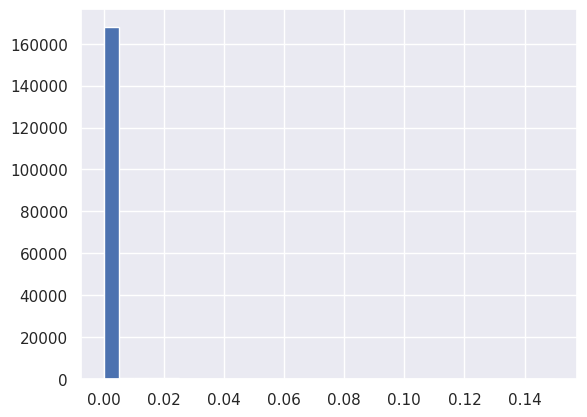

In [126]:
plt.hist((agg_proba['prob_LVL3_MACROPHAGE_KUPFFER_LIKE']),bins = 30)
plt.show()

In [121]:
(agg_proba['prob_LVL3_MACROPHAGE_KUPFFER_LIKE'])

Wang_et_al_AAACCTGAGACCTTTG_1-0    0.0
Wang_et_al_AAACCTGCACTTAAGC_1-0    0.0
Wang_et_al_AAACCTGGTAACGACG_1-0    0.0
Wang_et_al_AAACCTGGTCAAAGAT_1-0    0.0
Wang_et_al_AAACCTGGTCCGAAGA_1-0    0.0
                                  ... 
TTTGTCATCCTCTAGC-1-5-3             0.0
TTTGTCATCGCCGTGA-1-5-3             0.0
TTTGTCATCGTTTAGG-1-5-3             0.0
TTTGTCATCTGACCTC-1-5-3             0.0
TTTGTCATCTGCTTGC-1-5-3             0.0
Name: prob_LVL3_MACROPHAGE_KUPFFER_LIKE, Length: 169494, dtype: float64

In [95]:
pseudobulk_labels = ['LVL3']
main_annotations = None

# Handle single string input for pseudobulk_labels
if isinstance(pseudobulk_labels, str):
    pseudobulk_labels = [pseudobulk_labels]

pseudobulk_cell_indices = np.where(adata.obs.index.isin(pseudobulk_adata.obs.index))[0]
n_relevant_cells = len(pseudobulk_cell_indices)
n_chunks = (n_relevant_cells + chunk_size - 1) // chunk_size  # Ceiling division

probabilities = lil_matrix((n_relevant_cells, connectivity_matrix.shape[1]))

for chunk_idx in tqdm(range(n_chunks), desc="Computing probabilities", unit="chunk"):
    chunk_start = chunk_idx * chunk_size
    chunk_end = min(chunk_start + chunk_size, n_relevant_cells)

    chunk_indices = pseudobulk_cell_indices[chunk_start:chunk_end]
    inverse_distance_chunk = connectivity_matrix[chunk_indices, :].tocsc()
    row_sums_chunk = inverse_distance_chunk.sum(axis=1).A1

    for i, row_sum in enumerate(row_sums_chunk):
        probabilities[chunk_start + i, :] = inverse_distance_chunk[i, :] / row_sum

results = {}
for label in pseudobulk_labels:
    label_data = pseudobulk_adata.obs[label].values
    unique_labels = np.unique(label_data)

    label_probabilities = np.array([probabilities[:, label_data == label_value].sum(axis=1) for label_value in unique_labels]).T

    if main_annotations is not None:
        penalties = np.apply_along_axis(entropy, 1, label_probabilities, q=main_annotations)
    else:
        # Using neighborhood dispersion as penalty when main_annotations is not provided
        penalties = compute_neighborhood_dispersion(connectivity_matrix, pseudobulk_cell_indices, chunk_size=chunk_size)

    penalized_probabilities = label_probabilities * (1 - penalties[:, np.newaxis])

    # Debugging prints
    print(f"Unique labels shape: {unique_labels.shape}")
    print(f"Penalized probabilities shape: {penalized_probabilities.shape}")

    # Assigning labels based on max probability
    max_indices = np.argmax(penalized_probabilities, axis=1)
    print(f"Max indices: {max_indices}")
    assigned_labels = unique_labels[max_indices]
    confidence = np.max(penalized_probabilities, axis=1)

    # Constructing DataFrame
    df = pd.DataFrame(penalized_probabilities, columns=unique_labels)
    df["Assigned Label"] = assigned_labels
    df["Confidence"] = confidence
    results[label] = df

Computing probabilities: 100%|██████████| 17/17 [01:45<00:00,  6.23s/chunk]


Number of chunks: 17


Computing dispersion: 100%|██████████| 17/17 [00:15<00:00,  1.11chunk/s]

Unique labels shape: (49,)
Penalized probabilities shape: (1, 16949, 49)
Max indices: [[  136   107   975 13600  9297  1168  1206   998  1720  1036  3362   846
    767   732   434  1040   860 11037   592  1522  1557   413  1049 10771
   1112 14296 12397   653  1108   101   922  1668   740   923  1528  1212
  16397  1198  1682   757 15162  1236   412    25  1053 16313  1411 15049
   1072]]


IndexError: index 136 is out of bounds for axis 0 with size 49

In [107]:
label_probabilities.shape

(1, 16949, 49)

In [108]:
pd.DataFrame(label_probabilities)

ValueError: Must pass 2-d input. shape=(1, 16949, 49)

In [102]:
max_indices

array([[  136,   107,   975, 13600,  9297,  1168,  1206,   998,  1720,
         1036,  3362,   846,   767,   732,   434,  1040,   860, 11037,
          592,  1522,  1557,   413,  1049, 10771,  1112, 14296, 12397,
          653,  1108,   101,   922,  1668,   740,   923,  1528,  1212,
        16397,  1198,  1682,   757, 15162,  1236,   412,    25,  1053,
        16313,  1411, 15049,  1072]])

In [99]:
unique_labels.shape

(49,)

In [41]:
pseudobulk_adata.obs[label]

CTGAAGTTCAAACAAG-1-1-3                                   MACROPHAGE_KUPFFER_LIKE
F80_Yolksac_CD45P_FCAImmP8096693_GATCGCGGTCAGCTAT-0    MACROPHAGE_IRON_RECYCLING
F61_Yolksac_CD45N_FCAImmP7862092_ATAACGCTCCTTGACC-0                    ERYTHROID
Wang_et_al_GTGCAGCGTTAGTGGG_2-0                                      PRIM_HSPC_1
AAGGCAGGTCTTGCGG-1-2-3                                                 ERYTHROID
                                                                 ...            
F80_Yolksac_CD45P_FCAImmP8096693_TACACGACATGTCCTC-0      MACROPHAGE_KUPFFER_LIKE
F80_Yolksac_CD45N_FCAImmP8096695_TGAGCCGAGCCTTGAT-0                    ERYTHROID
F37_Yolksac_Total_FCAImmP7504910_AGCATACGTTGAACTC-0    MACROPHAGE_IRON_RECYCLING
CTCGTACTCCTTGGTC-1-5-3                                               MESOTHELIUM
F79_Yolksac_CD45N_FCAImmP8096691_CAACCAACAAGCTGTT-0                    ERYTHROID
Name: LVL3, Length: 16949, dtype: category
Categories (49, object): ['CMP', 'DC2_CYCLING', 'DEF_HSPC_1', 'DEF

In [38]:
unique_labels

array(['CMP', 'DC2_CYCLING', 'DEF_HSPC_1', 'DEF_HSPC_2',
       'EARLY_ERYTHROID', 'ELP', 'ENDODERM', 'ENDOTHELIUM_AEC',
       'ENDOTHELIUM_PROLIF_AEC', 'ENDOTHELIUM_PROLIF_SINUSOIDAL_EC',
       'ENDOTHELIUM_SINUSOIDAL', 'ENDOTHELIUM_VWF', 'EOSINOPHIL_BASOPHIL',
       'EO_BASO_MAST_PRECURSOR', 'ERYTHROID', 'FIBROBLAST', 'HE',
       'ILC_PRECURSOR', 'IMMATURE_ENDOTHELIUM', 'LMPP', 'LYMPHOID B LIN',
       'MAC DC2', 'MACROPHAGE_IRON_RECYCLING', 'MACROPHAGE_KUPFFER_LIKE',
       'MACROPHAGE_LYVE1_HIGH', 'MACROPHAGE_MICROGLIA',
       'MACROPHAGE_PRE_MAC', 'MACROPHAGE_PROLIFERATING', 'MAST_CELL',
       'MEMP', 'MESOTHELIUM', 'MID_ERYTHROID', 'MK', 'MONO MAC DC2',
       'MONO MAC PRE DC2', 'MONOCYTE_0', 'MONOCYTE_1',
       'MONOCYTE_MACROPHAGE', 'MOP', 'NEUTROPHIL_PRECURSOR', 'NK',
       'PDC PRECURSOR', 'PRE DC2', 'PRIM_HSPC_1', 'PRIM_HSPC_2',
       'PROMONOCYTE', 'SMOOTH_MUSCLE', 'unassigned_HSPC_1',
       'unassigned_HSPC_2'], dtype=object)

In [37]:
penalized_probabilities.shape

(1, 16949, 49)

In [43]:
edge_weight_diff

261491.66

In [44]:
spectral_diff

2.409010314941406

In [45]:
bce_loss

1.1468778

In [46]:
evaluate_reconstruction_sparse(pseudobulk_adata, adata)

Error occurred: 'connectivities'


(nan, nan, nan, nan)

In [47]:
evaluate_reconstruction_sparse(adata_samp, adata)

(1.3752099752426148, 1.375207, 0.0, 3.0279159545898436e-06)

# Can we recover simple lineage transitions?

In [48]:
# Create pseudocells from the main data
#connectivity_matrix = adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']]
#pseudobulk_adata = scent.aggregate_data(adata, adata_samp, connectivity_matrix, method='local')

In [49]:
lineage_dict = {
'Macrophage_lin':
[
'HE',
 'MONOCYTE_0',
 'MONOCYTE_MACROPHAGE',
 'MACROPHAGE_PRE_MAC',
 'PRIM_HSPC_2',
 'CMP',
 'PRIM_HSPC_1',
 'MACROPHAGE_PROLIFERATING',
 'DEF_HSPC_2',
 'MACROPHAGE_MICROGLIA',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_IRON_RECYCLING',
 'DEF_HSPC_1',
 'ENDOTHELIUM_AEC',
 'PROMONOCYTE',
 'MACROPHAGE_KUPFFER_LIKE',
 'MONOCYTE_1',
 'MOP']
}
pseudobulk_adata_lin = pseudobulk_adata[pseudobulk_adata.obs['LVL3'].isin(lineage_dict['Macrophage_lin'])]
sc.pp.normalize_per_cell(pseudobulk_adata_lin, counts_per_cell_after=1e4)
sc.pp.log1p(pseudobulk_adata_lin)
print(np.max(pseudobulk_adata_lin.X))
sc.pp.highly_variable_genes(pseudobulk_adata_lin, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(pseudobulk_adata_lin,use_highly_variable=True)
sc.pp.neighbors(pseudobulk_adata_lin, n_neighbors=15, n_pcs=30)

7.536113


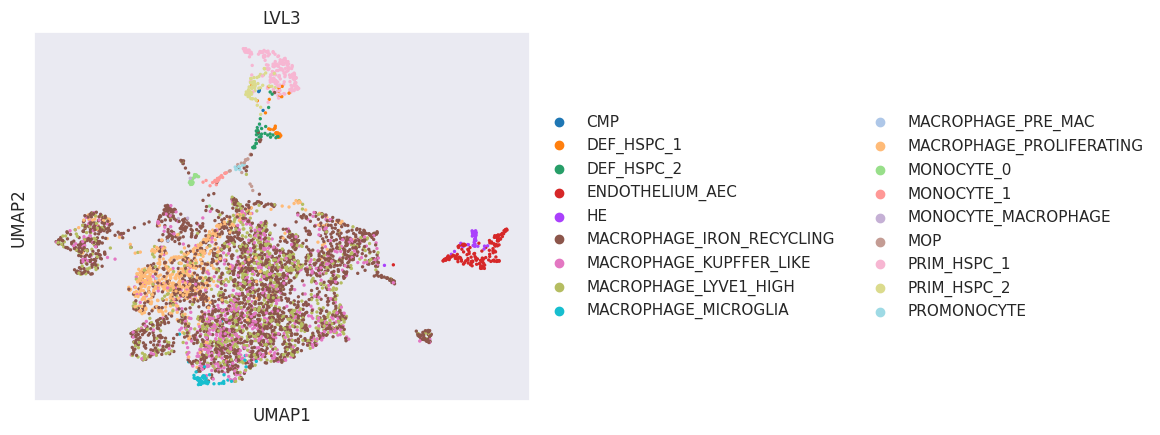

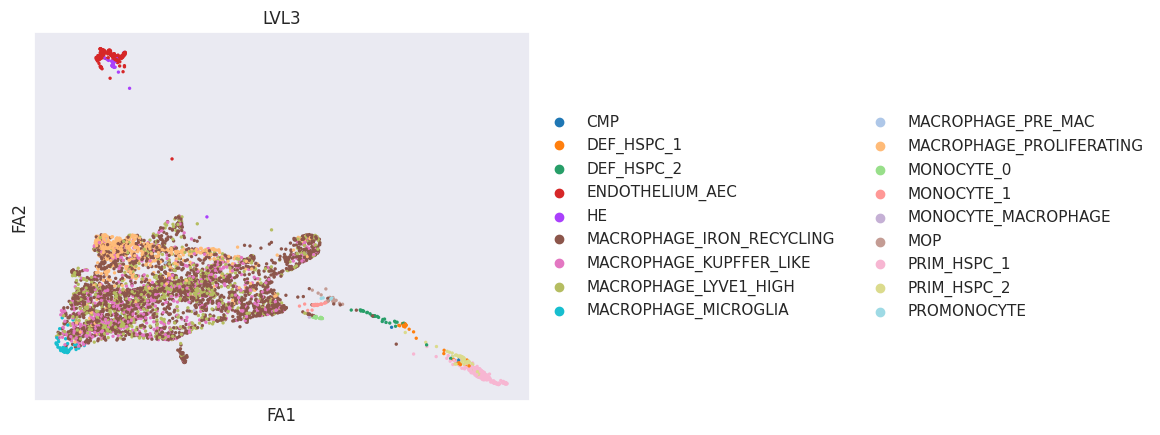

In [50]:
#pseudobulk_adata.obsm = adata_samp.obsm
sc.tl.umap(pseudobulk_adata_lin)
sc.pl.umap(pseudobulk_adata_lin,color = 'LVL3')
sc.tl.draw_graph(pseudobulk_adata_lin, layout='fa', init_pos=None)
sc.pl.draw_graph(pseudobulk_adata_lin, color = 'LVL3')

8.256158


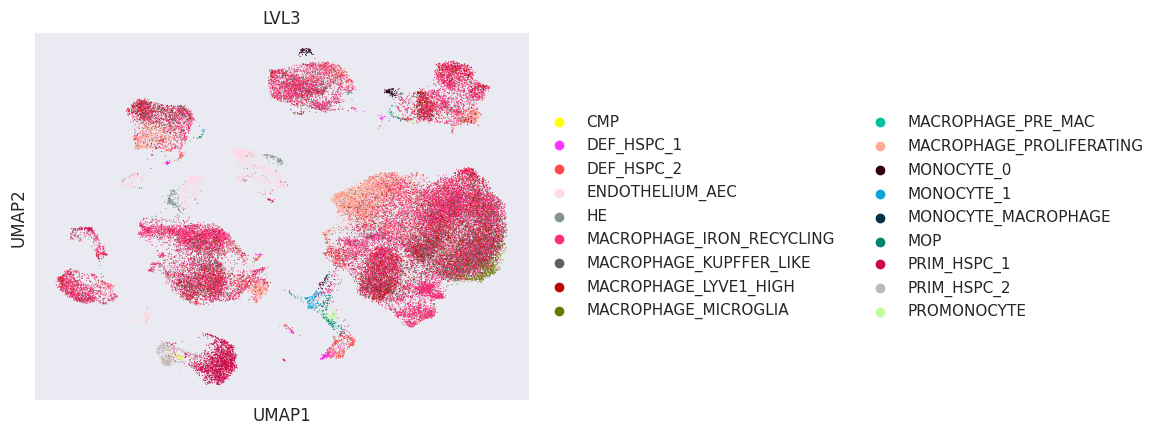

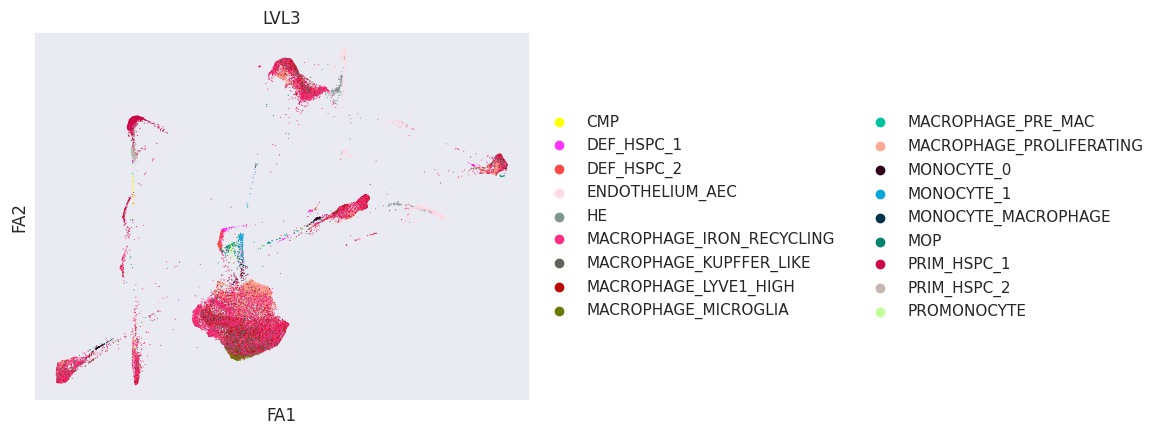

In [51]:
lineage_dict = {
'Macrophage_lin':
[
'HE',
 'MONOCYTE_0',
 'MONOCYTE_MACROPHAGE',
 'MACROPHAGE_PRE_MAC',
 'PRIM_HSPC_2',
 'CMP',
 'PRIM_HSPC_1',
 'MACROPHAGE_PROLIFERATING',
 'DEF_HSPC_2',
 'MACROPHAGE_MICROGLIA',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_IRON_RECYCLING',
 'DEF_HSPC_1',
 'ENDOTHELIUM_AEC',
 'PROMONOCYTE',
 'MACROPHAGE_KUPFFER_LIKE',
 'MONOCYTE_1',
 'MOP']
}
test_adata_lin = adata[adata.obs['LVL3'].isin(lineage_dict['Macrophage_lin'])]
sc.pp.normalize_per_cell(test_adata_lin, counts_per_cell_after=1e4)
sc.pp.log1p(test_adata_lin)
print(np.max(test_adata_lin.X))
sc.pp.highly_variable_genes(test_adata_lin, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(test_adata_lin,use_highly_variable=True)
sc.pp.neighbors(test_adata_lin, n_neighbors=15, n_pcs=30)
#pseudobulk_adata.obsm = adata_samp.obsm
sc.tl.umap(test_adata_lin)
sc.pl.umap(test_adata_lin,color = 'LVL3')
sc.tl.draw_graph(test_adata_lin, layout='fa', init_pos=None)
sc.pl.draw_graph(test_adata_lin, color = 'LVL3')

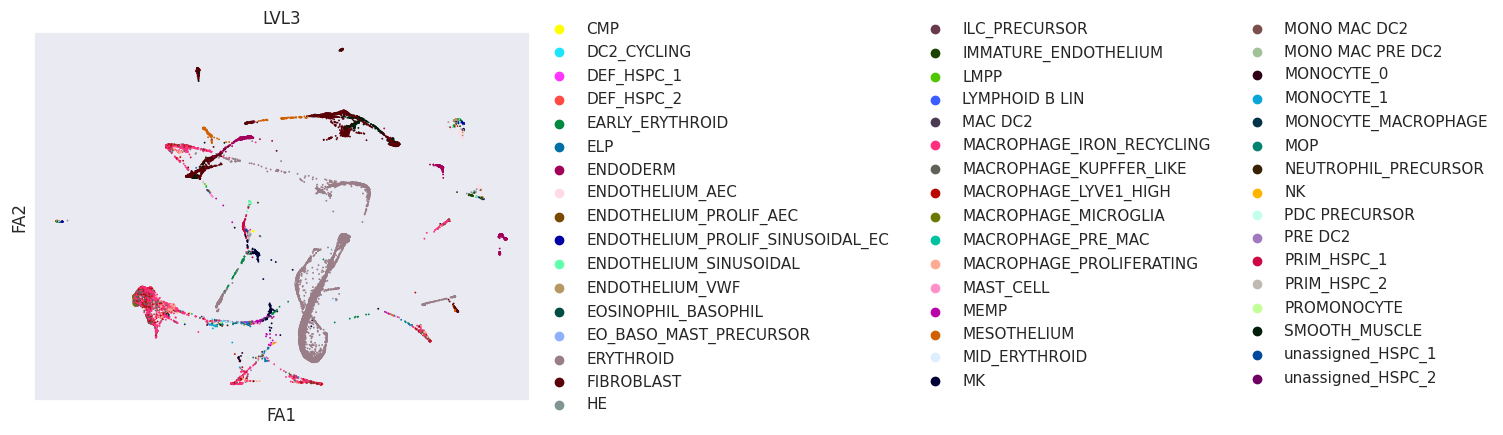

In [49]:
sc.pp.highly_variable_genes(pseudobulk_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(pseudobulk_adata,use_highly_variable=True)
sc.pp.neighbors(pseudobulk_adata, n_neighbors=30, n_pcs=30)
sc.tl.draw_graph(pseudobulk_adata, layout='fa', init_pos=None)
sc.pl.draw_graph(pseudobulk_adata, color = 'LVL3')

# Let's test a model trained using the psuedosampled data

In [70]:
pseudobulk_adata_write = pseudobulk_adata.copy()
del pseudobulk_adata_write.uns
del pseudobulk_adata_write.obsm
del pseudobulk_adata_write.obsp
pseudobulk_adata.write('./test_pseudobulked_adata.h5ad')

In [75]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
'int_atlas_sub':'/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/example_notebooks/Simple_sampled_adata_V1.h5ad',
'int_atlas_full':'/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad',
'test_psd_YS_adata':'/nfs/team205/ig7/resources/github/A0.1.0_SCENTINEL/example_notebooks/Dev_models/test_pseudobulked_adata.h5ad',
}

#setup global params:
# Variable assignment
train_model = True
adata_key = 'test_psd_YS_adata'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'X_psd_ys_non_strat'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'LVL3'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = True # should data be normalised?

# setup model parameters:
model_params = {
'feat_use': 'LVL3',
'train_x_partition' : 'X', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : False, # Current implementation is very expensive, intentionally made rigid for now
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
    
# Stratified Bayes sampler kwargs
'sample_data_knn':False
}

In [76]:
adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)

if model_params['sample_data_knn'] != False:
    print('Empirical bayes sampling option selected')
    adata_samp, indices, weights = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, **model_params)
    scent.plot_sampling_metrics(adata,adata_samp, **model_params)
    adata = adata_samp.to_memory()
print('adata_loaded')

option to apply standardisation to data detected, performing basic QC filtering
adata_loaded


# Train the EN model

In [ ]:
if train_model == True:
    from sklearn.preprocessing import StandardScaler
    #adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
    #if sample_data_knn != False:
    #    print('Empirical bayes sampling option selected')
    #    adata, indices = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, use_var, knn_key, sampling_rate= sample_data_knn, iterations=10, equal_allocation=False)
    #print('adata_loaded')
    import time
    t0 = time.time()
    display_cpu = scent.DisplayCPU()
    display_cpu.start()
    try:
        model_trained = scent.prep_training_data(
        adata_temp = adata,
        model_key = model_key + '_lr_model',
        **model_params
        )
        filename =model_name
        pkl.dump(model_trained, open(filename, 'wb'))
    finally: #
        current, peak = display_cpu.stop()
        t1 = time.time()
        time_s = t1-t0
        print('training complete!')
        time.sleep(3)
        print('projection time was ' + str(time_s) + ' seconds')
        print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
        print(f"starting memory usage is" +'' + str(display_cpu.starting))
        print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
        print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))
    model_lr= model_trained
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key)
else:
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key,QC_normalise)
    model = scent.load_models(models,model_key)
    model_lr =  model
    
# run with usage logger
import time
t0 = time.time()
display_cpu = scent.DisplayCPU()
display_cpu.start()
try: #code here ##
    pred_out,train_x,model_lr,adata_temp = scent.reference_projection(adata, model_lr, **model_params)
    if freq_redist != False:
        pred_out['orig_labels'] = adata.obs[freq_redist]
        pred_out = scent.freq_redist_68CI(pred_out,'orig_labels')
        adata.obs['consensus_clus_prediction'] = pred_out['consensus_clus_prediction']
    adata.obs['predicted'] = pred_out['predicted']
    adata_temp.obs = adata.obs
    
    # Estimate top model features for class descrimination
    feature_importance = scent.estimate_important_features(model_lr, 100)
    mat = feature_importance.euler_pow_mat
    top_loadings = feature_importance.to_n_features_long

finally: #
    current, peak = display_cpu.stop()
t1 = time.time()
time_s = t1-t0
print('projection complete!')
time.sleep(3)
print('projection time was ' + str(time_s) + ' seconds')
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(f"starting memory usage is" +'' + str(display_cpu.starting))
print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))

0.5
proceeding to train model
0.5


In [ ]:
if train_model == True:
    train_label = adata.obs[feat_use].values
else:
    train_label = adata.obs['predicted'].values
scent.report_f1(model_lr,train_x, train_label)

In [ ]:
if train_model == True:
    scent.regression_results(pred_out, 'orig_labels','predicted',list(model_lr.classes_))
else:
    scent.regression_results(pred_out, 'predicted','predicted',list(model_lr.classes_))

# View by median probabilities per classification

In [ ]:
scent.plot_label_probability_heatmap(pred_out)

# View by cross-tabulation of two categorical attributes

In [ ]:
scent.plot_crosstab_heatmap(adata, 'LVL3', 'predicted')
scent.plot_crosstab_heatmap(adata, 'consensus_clus_prediction', 'predicted')
scent.plot_crosstab_heatmap(adata,  'LVL3','consensus_clus_prediction')

# View top predictive features per class

In [ ]:
top_loadings

In [ ]:
#Estimate dataset specific feature impact
from matplotlib import pyplot as plt
class_plot = list(model_lr.classes_)[0:3]
for classes in class_plot: #['pDC precursor_ys_HL','AEC_ys_HL']:
    scent.model_class_feature_plots(top_loadings, [str(classes)], 'e^coef','e^coef',20,'top_feat')
    plt.show()

In [ ]:
# if using a low-dim model like PCA or ldVAE which has a weights layer
# top_loadings = compute_weighted_impact(varm_file = '/nfs/team205/ig7/projects/fetal_skin/3_160523_probabillistic_projection_organoid_adt_fetl/A2_V2_ldvae_models/v3_ldvae_obsm_weights.csv',top_loadings =  top_loadings, threshold=0.05)

for class_lin in top_loadings['class'].unique():
    scent.model_class_feature_plots(top_loadings, [class_lin], 'e^coef','e^coef',max_len= 20,title = class_lin)
    scent.analyze_and_plot_feat_gsea(top_loadings,class_lin, max_len=20, pre_ranked=True, database='GO_Biological_Process_2021', cutoff=0.25, min_s=5)

# Proceed to compute transductive label transfer and study the error rate

## Initialise a new projection run
- Here we generalise the transductive model across the entire dataset

In [ ]:
models

In [ ]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
'X_psd_ys_non_strat':'',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
}

#setup global params:
# Variable assignment
train_model = False
adata_key = 'YS_local'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'X_psd_ys_non_strat'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'LVL3'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False # should data be normalised?
sample_data_knn = 0.1 # Apply empirical bayes sampling weighted by knn?

# setup model parameters:
model_params = {
'feat_use': 'LVL3',
'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
}

In [ ]:
if train_model == True:
    from sklearn.preprocessing import StandardScaler
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
    #if sample_data_knn != False:
    #    print('Empirical bayes sampling option selected')
    #    adata, indices = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, use_var, knn_key, sampling_rate= sample_data_knn, iterations=10, equal_allocation=False)
    #print('adata_loaded')
    import time
    t0 = time.time()
    display_cpu = scent.DisplayCPU()
    display_cpu.start()
    try:
        model_trained = scent.prep_training_data(
        adata_temp = adata,
        model_key = model_key + '_lr_model',
        **model_params
        )
        filename =model_name
        pkl.dump(model_trained, open(filename, 'wb'))
    finally: #
        current, peak = display_cpu.stop()
        t1 = time.time()
        time_s = t1-t0
        print('training complete!')
        time.sleep(3)
        print('projection time was ' + str(time_s) + ' seconds')
        print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
        print(f"starting memory usage is" +'' + str(display_cpu.starting))
        print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
        print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))
    model_lr= model_trained
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key)
else:
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key,QC_normalise)
    model = scent.load_models(models,model_key)
    model_lr =  model
    
# run with usage logger
import time
t0 = time.time()
display_cpu = scent.DisplayCPU()
display_cpu.start()
try: #code here ##
    pred_out,train_x,model_lr,adata_temp = scent.reference_projection(adata, model_lr, **model_params)
    if freq_redist != False:
        pred_out['orig_labels'] = adata.obs[freq_redist]
        pred_out = scent.freq_redist_68CI(pred_out,'orig_labels')
        adata.obs['consensus_clus_prediction'] = pred_out['consensus_clus_prediction']
    adata.obs['predicted'] = pred_out['predicted']
    adata_temp.obs = adata.obs
    
    # Estimate top model features for class descrimination
    feature_importance = scent.estimate_important_features(model_lr, 100)
    mat = feature_importance.euler_pow_mat
    top_loadings = feature_importance.to_n_features_long

finally: #
    current, peak = display_cpu.stop()
t1 = time.time()
time_s = t1-t0
print('projection complete!')
time.sleep(3)
print('projection time was ' + str(time_s) + ' seconds')
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(f"starting memory usage is" +'' + str(display_cpu.starting))
print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))

In [ ]:
if train_model == True:
    train_label = adata.obs[feat_use].values
else:
    train_label = adata.obs['predicted'].values
scent.report_f1(model_lr,train_x, train_label)

In [ ]:
if train_model == True:
    scent.regression_results(pred_out, 'orig_labels','predicted',list(model_lr.classes_))
else:
    scent.regression_results(pred_out, 'predicted','predicted',list(model_lr.classes_))

import scentinel# View by median probabilities per classification

In [ ]:
scent.plot_label_probability_heatmap(pred_out)

# View by cross-tabulation of two categorical attributes

In [ ]:
scent.plot_crosstab_heatmap(adata, 'cell.labels', 'predicted')
scent.plot_crosstab_heatmap(adata, 'consensus_clus_prediction', 'predicted')
scent.plot_crosstab_heatmap(adata,  'cell.labels','consensus_clus_prediction')

# Test SGDPR

In [3]:
def empirical_bayes_balanced_stratified_KNN_sampling(adata, feat_use, knn_key, sampling_rate=0.1, iterations=1,representation_priority = 0.9, equal_allocation=False, replace = True,weight_penalty='laplacian',pl_label_entropy=False,resample_clones=False, **kwargs):
    # Unpack kwargs
    if kwargs:
        for key, value in kwargs.items():
            globals()[key] = value
        kwargs.update(locals())
    if equal_allocation:
        print('You are using an equal allocation mode of sampling, be warned that this can cause errors if the smaller populations are insufficient in number, consider replace == True')

    if replace == True:
        print('You are using sampling with replacement, this allows the model to create clones of cells')

    if representation_priority > 0.8:
        print('warning: you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')
        warnings.warn('warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')

    # Convert string labels to integer labels
    unique_labels, indices = np.unique(adata.obs[feat_use], return_inverse=True)
    adata.obs['int.labels'] = indices

    # Calculate frequencies (prior probabilities)
    label_counts = np.bincount(indices)
    frequencies = label_counts / label_counts.sum()

    # Create a dictionary where keys are label indices and values are their frequencies (prior probabilities)
    prior_distribution = dict(zip(range(len(unique_labels)), frequencies))

    neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]

    # Initialize label probabilities with prior distribution
    label_probs = prior_distribution.copy()

    # Get indices for each label
    label_indices = {label: np.where(adata.obs['int.labels'] == label)[0] for label in range(len(unique_labels))}

    # Calculate total sample size and sample size per label for equal allocation
    total_sample_size = int(sampling_rate * adata.shape[0])
    sample_size_per_label = total_sample_size // len(unique_labels)

    if weight_penalty == 'entropy_distance':
        print('Using distance-entropy penalisation weights, this module is multi-threaded and quite compute intensive. If facing issues, use connectivity_ratio instead')
        # Calculate entropy for each neighborhood in advance
        all_labels = adata.obs['int.labels'].values
        neighborhood_indices = [np.nonzero(neighborhood_matrix[idx])[1] for idx in range(adata.shape[0])]
        # Calculate entropy for each cell in parallel
        import multiprocessing
        with multiprocessing.Pool() as pool:
                neighborhood_entropies = np.array(list(pool.map(calculate_entropy, [(all_labels, idx) for idx in neighborhood_indices])))

    elif weight_penalty == "laplacian":# This is essentially an attention score
        print('Using Laplacian penalty term, this is similar in concept to an attention score in GANs')
        # This is essentially the calculation of the Laplacian of the graph.
        # Calculate degrees
        degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
        # Calculate inverse square root of degrees
        inv_sqrt_degrees = 1 / np.sqrt(degrees)
        # Create diagonal matrix of inverse square root degrees
        inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
        # Apply transformation to the adjacency matrix
        normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix


    elif weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score
        print('Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
        # This is essentially the calculation of the Laplacian of the graph.
        # Calculate degrees
        degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
        # Calculate inverse square root of degrees
        inv_sqrt_degrees = 1 / np.sqrt(degrees)
        # Create diagonal matrix of inverse square root degrees
        inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
        # Apply transformation to the adjacency matrix
        normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
    #     # Now you can use normalized_matrix in place of neighborhood_matrix
    #     attention_score = normalized_matrix[indices].sum(axis = 1)
    # Convert your sparse matrix to a csr_matrix if it's not already
        csr_matrix = normalized_matrix.tocsr()
        attention_scores, l2_norm_dic = SGDpagerank(csr_matrix, num_iterations=1000,sampling_method='probability_based', mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, full_batch_update_iters=100)



    # Create a dictionary to store the neighborhood entropy for each label at each iteration
    neighborhood_entropies_iter = {label: [] for label in range(len(unique_labels))}
    sampling_probabilities_over_iterations = np.zeros((iterations, len(unique_labels)))
    for _ in range(iterations):
        print('Iteration: {}'.format(_))
        # Stratified sampling within each neighborhood for each label
        all_weights = []
        all_indices = []
        for label in label_indices.keys():
            indices = label_indices[label]
            other_indices = [idx for key, indices in label_indices.items() if key != label for idx in indices]

            neighborhoods = neighborhood_matrix[indices]  # select neighborhoods for the current label

            # Here we determine the liklighood that a sampled cell forms consistant neigthborhood
            # We take the sum of weights of the same labels within each neighborhood to represent the liklihood of a cell forming tight communities (px)
            # We divide p by the sum of weights of different labels in the same neighborhood to represent the liklihood of there being more than one state sharing the neighborhood. (nx)
            # We take the ratio of (px/nx) to represent the liklihood that a label represents consistant neighborhoods that are sufficiently independent
            # e.g The sum of weights of cells with different labels in a neighborhood relative to our observed cell should be low if the label for the cell is good. thus the ratio should be high.   
            if weight_penalty == 'connectivity_ratio':
                same_label_mask = np.array(adata.obs['int.labels'][indices] == label, dtype=int)  # get mask for same-label cells
                same_label_mask = scipy.sparse.diags(same_label_mask)  # convert to diagonal matrix for multiplication
                same_label_neighborhoods = neighborhoods[:, indices]   # get neighborhoods of same-label cells
                different_label_neighborhoods = neighborhoods[:,other_indices]  # get neighborhoods of different-label cells
                same_label_weights = np.array(same_label_neighborhoods.sum(axis=1)).ravel()
                different_label_weights = np.array(different_label_neighborhoods.sum(axis=1)).ravel()
                # we now compute a hybrid weighting scheme, where cells with more defined neigthborhood structure are prioritised. Howevever we do not want this over penalise, so we recover underrepresented cells with a inverse weighting parameter
                # Calculate the ratio of same-label weights to different-label weights
                # Add a small constant in the denominator to avoid division by zero
                weights = (same_label_weights )/ (different_label_weights + 1e-8) # if same label sum distances are 0, do not consider this cell
                weights = weights/np.sum(weights) # this normnalisation means that every label has normalised set of weights to bias selection

             # Here we determine the liklighood that a sampled cell forms consistant neigthborhood using the mean distance to all neighbors * by the entropy of the neighborhood 

            if weight_penalty == 'entropy_distance':
                # We take neighborhoods that share the same labels and compute the sum of weights between same labels
    #             np.array(neighborhoods[:, indices].sum(axis=1)).ravel()
                same_label_mask = np.array(adata.obs['int.labels'][indices] == label, dtype=int)  # get mask for same-label cells
                same_label_mask = scipy.sparse.diags(same_label_mask)  # convert to diagonal matrix for multiplication
                same_label_neighborhoods = neighborhoods[:, indices] 
                weights = (np.array(same_label_neighborhoods.sum(axis=1)).ravel()+ 1e-8) # We take the sum of weights to all neighbors of the same label here
                #1/weights give us the inverse where big weights are big distances
                weights *= (1/(neighborhood_entropies[indices] + 1e-8))  # use pre-computed entropies
    #             weights = weights
                weights = weights / np.sum(weights) # this normnalisation means that every label has normalised set of weights to bias selection

            elif weight_penalty == "laplacian":# This is essentially an attention score
                # This is essentially the calculation of the Laplacian of the graph.
                # Compute the attention or importance of each cell to their neighbors
                attention_scores=normalized_matrix[indices].sum(axis = 1)
                weights = ((np.array(attention_scores)).flatten())

            elif weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score with pagerank and stochastic gradient descent
                # This is essentially the calculation of the Laplacian of the graph.
                # Compute the attention or importance of each cell to their neighbors
                attention_scores_= [attention_scores[i] for i in indices]
                weights = ((np.array(attention_scores_)).flatten())

            # Update weights based on representation priority and label probabilities
            # This should be a combination of the neighborhood-based weights and the label probability-based weights
            # we intriduce a iteration decay for each iteration for label probs here
            if representation_priority != 0:
                #weights = weights * ((((1 / (label_probs[label] + 1e-8))) **  (representation_priority)) )
                weights = weights * ((((1 / (label_probs[label] + 1e-8))) **  (representation_priority/(1+_))) )# we added a decaying upsampling factor to prevent iterations from over sampling under re-presented states
            else:
                #weights = weights * (((1 / (label_probs[label] + 1e-8))))
                weights = weights * (((1 / (label_probs[label] + 1e-8)))) 
            #weights = np.array(weights) / np.sum(weights)  # normalization to probabilities
            all_weights.extend(weights)
            all_indices.extend(indices)

        all_weights = np.array(all_weights) / np.sum(all_weights)  # normalization to probabilities

        if resample_clones == True:
            sample_indices_n_dic = {}
            for _niter in range(0,50):
                sample_indices_n = np.random.choice(all_indices, size=total_sample_size, replace=replace, p=all_weights)
                sample_indices_n_dic[_niter] = sample_indices_n
            sample_indices_n_dic
            # Combine all the samples into one list
            combined_samples = np.hstack(list(sample_indices_n_dic.values()))
            # Count the frequency of each index in the combined samples
            index_counts = Counter(combined_samples)
            # Create a new weight array where the weight of each index is its original weight divided by its count
            new_weights = np.array([all_weights[i] / (1.0 + index_counts.get(index, 0)) for i, index in enumerate(all_indices)])
            # Normalize the new weights so they sum to 1
            new_weights /= new_weights.sum()
            # Sample from the distribution with the adjusted weights
            sample_indices = np.random.choice(all_indices, size=total_sample_size, replace=True, p=new_weights)
            # The result is a new sample where the frequently appearing indices in the initial samples have a lower chance of appearing
        else:
            sample_indices = np.random.choice(all_indices, size=total_sample_size, replace=replace, p=all_weights)

        # Update label probabilities based on the observed sample
        sample_labels = adata.obs['int.labels'][sample_indices]
        label_counts = np.bincount(sample_labels, minlength=len(unique_labels))
        label_probs = dict(zip(range(len(unique_labels)), label_counts / label_counts.sum()+1e-8))
        # Store the sampling probabilities for this iteration
        sampling_probabilities_over_iterations[_, :] = np.array(list(label_probs.values()))

        if pl_label_entropy == True:
            # Calculate the entropy for the sampled cells
            for label in label_indices.keys():
                # Get the indices of the sampled cells for the current label
                sampled_indices = [idx for idx in sample_indices if adata.obs['int.labels'][idx] == label]
                if sampled_indices:
                    # Get neighborhoods of the sampled cells
                    same_label_neighborhoods = neighborhood_matrix[sampled_indices]
                    # Get the indices of the connected cells
                    connected_indices = same_label_neighborhoods.nonzero()[1]
                    # Get the labels of the connected cells
                    connected_labels = adata.obs['int.labels'].values[connected_indices]
                    # Calculate the entropy for the current label
                    label_counts = np.bincount(connected_labels, minlength=len(unique_labels))
                    probabilities = label_counts / len(connected_indices)
                    entropy_val = entropy(probabilities)
                    neighborhood_entropies_iter[label].append(entropy_val)
                else:
                    neighborhood_entropies_iter[label].append(None)

    average_sampling_probabilities = sampling_probabilities_over_iterations.mean(axis=0)
    updated_label_probs = dict(zip(range(len(unique_labels)), average_sampling_probabilities))

    # Final stratified sampling using the last label_probs
    label_sample_sizes = {label: int(updated_label_probs[label] * total_sample_size) for label in range(len(unique_labels))}
    # Adjust sample sizes so total equals 'total_sample_size'
    difference = total_sample_size - sum(label_sample_sizes.values())
    label_sample_sizes[0] += difference  # adjust the first label for simplicity
    final_sample_indices = []

    if equal_allocation==True:
        label_sample_sizes = {label: sample_size_per_label for label in range(len(unique_labels))}

    for label, sample_size in label_sample_sizes.items():
        indices = label_indices[label]
        neighborhoods = neighborhood_matrix[indices][:, indices]  # select neighborhoods for the current label

        same_label_mask = np.array(adata.obs['int.labels'][indices] == label, dtype=int)  # get mask for same-label cells
        same_label_mask = scipy.sparse.diags(same_label_mask)  # convert to diagonal matrix for multiplication

        same_label_neighborhoods = same_label_mask @ neighborhoods @ same_label_mask  # get neighborhoods of same-label cells
        different_label_neighborhoods = neighborhoods - same_label_neighborhoods  # get neighborhoods of different-label cells

        same_label_weights = np.array(same_label_neighborhoods.sum(axis=1)).ravel()
        different_label_weights = np.array(different_label_neighborhoods.sum(axis=1)).ravel()

        # Calculate the ratio of same-label weights to different-label weights
        # Add a small constant in the denominator to avoid division by zero
        #weights = same_label_weights / (different_label_weights + 1e-8)
    #     weights = weights / weights.sum()  # normalization to probabilities
        specific_weights = np.array(all_weights[indices]) / np.sum(all_weights[indices])

        if resample_clones == True:
    #         sample_indices = np.random.choice(indices, size=sample_size, replace=replace, p=specific_weights)
    #         print('prior Non-Clone proportion == {}'.format( (len(list(set(sample_indices)))/len(sample_indices))))
            sample_indices_n_dic = {}
            for _niter in range(0,50):
                try:
                    sample_indices_n = np.random.choice(indices, size=sample_size, replace=replace, p=specific_weights)
                except:
                    print('Warning -- sampling for {} without replacement failed, defaulting to taking all cells in this category'.format(label))
                    sample_indices_n = np.random.choice(indices, size=len(indices), replace=replace, p=specific_weights)
                sample_indices_n_dic[_niter] = sample_indices_n
            sample_indices_n_dic
            # Combine all the samples into one list
            combined_samples = np.hstack(list(sample_indices_n_dic.values()))
            # Count the frequency of each index in the combined samples
            index_counts = Counter(combined_samples)
            # Create a new weight array where the weight of each index is its original weight divided by its count
            new_weights = np.array([specific_weights[i] / (1.0 + index_counts.get(index, 0)) for i, index in enumerate(indices)])
            # Normalize the new weights so they sum to 1
            new_weights /= new_weights.sum()
            # Sample from the distribution with the adjusted weights
            sampled_indices = np.random.choice(indices, size=sample_size, replace=True, p=new_weights)
            # The result is a new sample where the frequently appearing indices in the initial samples have a lower chance of appearing
    #         print('resampled Non-Clone proportion == {}'.format( (len(list(set(sample_indices)))/len(sample_indices))))
        else:
            sampled_indices = np.random.choice(indices, size=sample_size, replace=replace, p=specific_weights)

    #     sampled_indices = np.random.choice(indices, size=sample_size, replace=replace, p=specific_weights)
        final_sample_indices.extend(sampled_indices)
    adata_samp = adata[final_sample_indices,:]
    all_weights


    if pl_label_entropy == True:
        # plot entropy change per iteration
        # Calculate the number of columns for the legend
        ncol = math.ceil(len(unique_labels) / 20)  # Adjust the denominator to control the number of legend entries per column

        # Create a figure and an axes object
        fig, ax = plt.subplots(figsize=(5 + ncol, 5))  # Adjust as needed. The width of the axes object will be always 5.

        # Compute the initial entropies for the whole dataset
        initial_entropies = {}
        for label in label_indices.keys():
            indices = label_indices[label]
            same_label_neighborhoods = neighborhood_matrix[indices]
            connected_indices = same_label_neighborhoods.nonzero()[1]
            connected_labels = adata.obs['int.labels'].values[connected_indices]
            label_counts = np.bincount(connected_labels, minlength=len(unique_labels))
            probabilities = label_counts / len(connected_indices)
            entropy_val = entropy(probabilities)
            initial_entropies[label] = entropy_val

        # Plot the change in neighborhood entropy over iterations for each label
        for label, entropies in neighborhood_entropies_iter.items():
            # Prepend the initial entropy to the list of entropies
            all_entropies = [initial_entropies[label]] + entropies
            ax.plot(range(len(all_entropies)), all_entropies, label=unique_labels[label])

        ax.set_xlabel('Iteration')
        ax.set_ylabel('Scaled Neighborhood Entropy')
        # Set the y-axis to logarithmic scale
        ax.set_yscale('log')
        # Place the legend outside the plot, scaled with the height of the plot and spread into columns
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=ncol)
        plt.tight_layout()
        plt.show()

    weights_out = {}
    weights_out['all_weights'] = all_weights
    weights_out['all_indices'] = all_indices
    return adata_samp, final_sample_indices, weights_out



def SGDpagerank(M, num_iterations=1000, mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, 
             full_batch_update_iters=10, dip_window=5, plateau_iterations=5, sampling_method='probability_based'):
    """
    Calculate the PageRank of each node in a graph using a mini-batch SGD approach.

    Parameters:
    - M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
    - num_iterations (int): The maximum number of iterations to perform.
    - mini_batch_size (int): Number of nodes to sample in each iteration.
    - initial_learning_rate (float): Initial learning rate for the SGD updates.
    - tolerance (float): Convergence threshold.
    - d (float): Damping factor.
    - full_batch_update_iters (int): Number of iterations for the full-batch update phase.
    - dip_window (int): Window size for smoothing L2 norms.
    - plateau_iterations (int): Number of consecutive iterations where the gradient should remain stable for early stopping.
    - sampling_method (str): Method to sample nodes ('probability_based' or 'cyclic').

    Returns:
    - numpy.ndarray: The PageRank score for each node in the graph.
    - dict: L2 norms for each iteration.
    """
    
    # Initialize the size of the matrix
    N = M.shape[1]
    
    # Initialize PageRank vector with random values and normalize
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    
    # Initialize last PageRank vector to infinity for convergence checks
    last_v = np.ones((N, 1)) * np.inf
    
    # Dictionary to store L2 norms for each iteration
    l2_dic = {}
    
    # Set to keep track of visited nodes (for cyclic sampling)
    visited_nodes = set()
    
    # Initialize counters and lists for plateau and dip detection
    plateau_count = 0
    dips_detected = 0
    dip_positions = []

    # Initialize an array to keep track of node visit counts (for probability-based sampling)
    visited_counts = np.zeros(N)

    for iter_ in range(num_iterations):
        # Decay the learning rate to ensure convergence
        learning_rate = initial_learning_rate / ((1 + iter_)/10)
        
        # Probability-based sampling
        if sampling_method == 'probability_based':
            probabilities = 1 / (1 + visited_counts)
            probabilities /= probabilities.sum()
            mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False, p=probabilities)
        
        # Cyclic sampling
        elif sampling_method == 'cyclic':
            if len(visited_nodes) < N:
                remaining_nodes = list(set(range(N)) - visited_nodes)
                mini_batch_indices = np.random.choice(remaining_nodes, size=min(mini_batch_size, len(remaining_nodes)), replace=False)
            else:
                mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False)
            
            # Update the set of visited nodes
            visited_nodes.update(mini_batch_indices)
        
        # Update node visit counts
        visited_counts[mini_batch_indices] += 1
        
        # Extract the mini-batch from the matrix and the PageRank vector
        M_mini_batch = M[mini_batch_indices, :]
        v_mini_batch = v[mini_batch_indices]
        
        # Store the current PageRank values for convergence checks
        last_v = v_mini_batch
        
        # Update the PageRank values using the mini-batch
        v_mini_batch = d * (learning_rate * M_mini_batch @ v) + ((1 - d) / N)
        v[mini_batch_indices] = v_mini_batch
        
        # Compute and store the L2 norm of the difference between the current and last PageRank values
        l2_norm = np.linalg.norm(v_mini_batch - last_v)
        l2_dic[iter_] = l2_norm
        
        # Compute smoothed L2 norms for dip detection
        if iter_ > dip_window:
            smoothed_values = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
            gradient = smoothed_values[-1] - smoothed_values[-2]
            
            # Detect dips in the smoothed L2 norms
            if gradient < -1.5 * np.std(smoothed_values):
                dips_detected += 1
                dip_positions.append(iter_)

        # Check for convergence
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(iter_))
            break
        
        # Early stopping based on smoothed L2 norms
        gradient_variance_window = 10
        if iter_ > gradient_variance_window:
            gradient_values = np.diff(smoothed_values)
            variance_of_gradient = np.var(gradient_values[-gradient_variance_window:])
            
            if sampling_method == 'probability_based' and dips_detected == 1:
                if abs(gradient_values[-1]) < 0.3 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            elif sampling_method == 'cyclic' and dips_detected > 1:
                if abs(gradient) < 0.5 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            # If the gradient has been stable for a number of iterations, stop early
            if plateau_count >= plateau_iterations:
                print(f'Early stopping at iteration {iter_} due to plateau in L2 norm changes.')
                break

    # If the algorithm hasn't converged in the given number of iterations, display a message
    if iter_ == num_iterations-1:
        print('pagerank model did not converge during the mini-batch phase')
    
    # Refine the PageRank values using full-batch updates
    print("Proceeding on to perform fine-tuning across full-batch")
    for _ in range(full_batch_update_iters):
        last_v_global = v.copy()
        v = d * (M @ v) + ((1 - d) / N)
        l2_norm_global = np.linalg.norm(v - last_v_global)
        l2_dic[iter_ + _ + 1] = l2_norm_global
        # break loop if L2norm < tolereance
#         if l2_norm_global <= tolerance:
#             break
    
    # Plot the L2 norms, smoothed L2 norms, dips, and detected plateaus
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_dic.keys()), list(l2_dic.values()), label="Original L2 Norm")
    smoothed_l2 = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
    plt.plot(range(dip_window - 1, dip_window - 1 + len(smoothed_l2)), smoothed_l2, 'r-', label="Smoothed L2 Norm")
    
    for dip in dip_positions:
        plt.axvline(x=dip, color='g', linestyle='--')
    
    if plateau_count >= plateau_iterations:
        plt.axvspan(iter_ - plateau_count + 1, iter_, color='yellow', alpha=0.2, label="Detected Plateau")

    # Highlight the global fine-tuning iterations
    plt.axvspan(iter_ + 1, iter_ + full_batch_update_iters + 1, color='blue', alpha=0.1, label="Global Fine-Tuning Iterations")

    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    if sampling_method == 'probability_based':
        print("You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data")
        print("Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement")
    elif sampling_method == 'cyclic':
        print("You should observe two dips in the graph, the first post initialisation and the second when the model starts to learn some structure and making informed updates")
        print("Erratic behavious post this second dip should trend downwards. This shows that dispite having visited all nodes and thus oscillating, we still see gradual model improvement")
    
    return v, l2_dic

def pagerank(M, num_iterations=100, d=0.85, tolerance=1e-6):
    """
    Calculate the PageRank of each node in a graph.
    
    Parameters:
    M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
    num_iterations (int): The maximum number of iterations to perform.
    d (float): The damping factor.
    tolerance (float): The tolerance for convergence.
    
    Returns:
    numpy.ndarray: The PageRank score for each node in the graph.
    """
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    damping = ((1 - d) / N) * np.ones((N, 1))
    last_v = np.ones((N, 1)) * np.inf
    l2_dic = {}
    for _ in range(num_iterations):
        last_v = v
        v = d * M @ v + damping
        l2_norm = np.linalg.norm(v - last_v)
        l2_dic[_] = l2_norm
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(_))
            break
            
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_dic.keys()), list(l2_dic.values()))
    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.grid(True)
    plt.show()

    return v, l2_dic



class ResourceMonitor:
    def __init__(self):
        self.control_queue = Queue()
        self.memory_data = []
        self.cpu_data = []
        self.time_data = []
        self.thread = None

    def monitor_resources(self, interval=1):
        """Monitor system resources at intervals."""
        while True:
            try:
                message = self.control_queue.get(timeout=interval)
                if message == "stop":
                    break
            except Empty:
                pass

            self.memory_data.append(psutil.virtual_memory().used / (1024 ** 2))
            self.cpu_data.append(psutil.cpu_percent(interval=None))
            self.time_data.append(time.time())

    def start_monitoring(self, interval=1):
        """Start the monitoring in a separate thread."""
        self.thread = threading.Thread(target=self.monitor_resources, args=(interval,))
        self.thread.start()

    def stop_monitoring(self):
        """Stop the monitoring."""
        self.control_queue.put("stop")
        if self.thread:
            self.thread.join()

def plot_resources():
    """Plot the collected resource data."""
    plt.figure(figsize=(12, 10))
    
    # Memory Usage Over Time
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(time_data, memory_data, '-o', color="blue", label="Memory Usage")
    ax1.fill_between(time_data, 0, memory_data, color="blue", alpha=0.3)
    ax1.set_ylim(min(memory_data) - 0.1 * min(memory_data), max(memory_data) + 0.1 * max(memory_data))
    
    # Add smoothed spline for memory data
    spl_memory = UnivariateSpline(time_data, memory_data, s=100)
    ax1.plot(time_data, spl_memory(time_data), 'k-', linewidth=2, label="Smoothed Memory Usage")
    
    ax1.set_title("Memory Usage Over Time")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Memory (MB)")
    ax1.legend()
    
    # CPU Usage Over Time
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(time_data, cpu_data, '-o', color="red", label="CPU Usage")
    ax2.fill_between(time_data, 0, cpu_data, color="red", alpha=0.3)
    ax2.set_ylim(min(cpu_data) - 5, max(cpu_data) + 5)  # giving a buffer of 5% for CPU
    # Add smoothed spline for CPU data
    spl_cpu = UnivariateSpline(time_data, cpu_data, s=10)
    ax2.plot(time_data, spl_cpu(time_data), 'k-', linewidth=2, label="Smoothed CPU Usage")
    
    ax2.set_title("CPU Usage Over Time")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("CPU (%)")
    ax2.legend()
    
    # Histogram for Memory Usage
    ax3 = plt.subplot(2, 2, 3)
    ax3.hist(memory_data, bins=30, color="blue", alpha=0.7)
    ax3.set_title("Histogram of Memory Usage")
    ax3.set_xlabel("Memory (MB)")
    ax3.set_ylabel("Frequency")
    
    # Histogram for CPU Usage
    ax4 = plt.subplot(2, 2, 4)
    ax4.hist(cpu_data, bins=30, color="red", alpha=0.7)
    ax4.set_title("Histogram of CPU Usage")
    ax4.set_xlabel("CPU (%)")
    ax4.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()



In [4]:
adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed='r')

Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
pagerank model did not converge during the mini-batch phase
Proceeding on to perform fine-tuning across full-batch


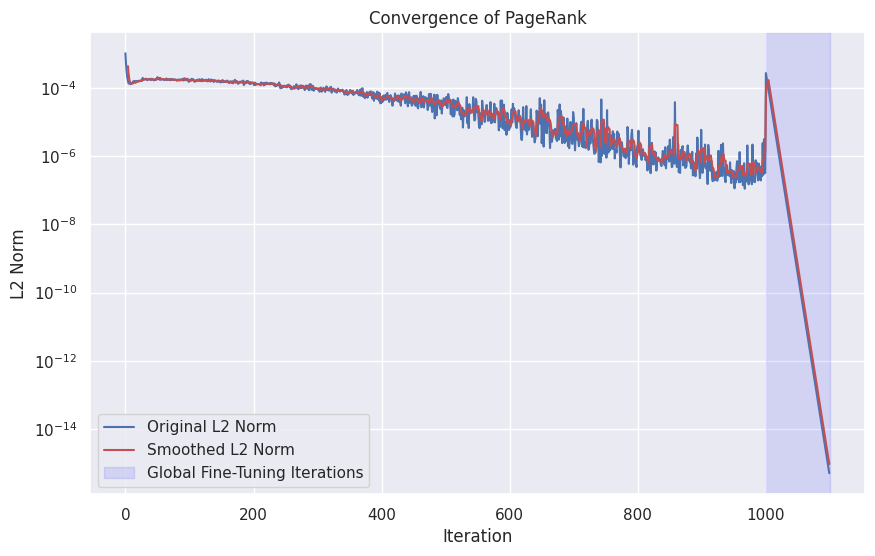

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement


In [5]:
neighborhood_matrix = adata.obsp['connectivities']
weight_penalty = "laplacian_SGD_pagerank"
if weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score
    print('Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
#     # Now you can use normalized_matrix in place of neighborhood_matrix
#     attention_score = normalized_matrix[indices].sum(axis = 1)
# Convert your sparse matrix to a csr_matrix if it's not already
    csr_matrix = normalized_matrix.tocsr()
    
    
attention_scores, l2_norm_dic = SGDpagerank(normalized_matrix, num_iterations=1000, mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-7, d=0.85, 
             full_batch_update_iters=100, dip_window=5, plateau_iterations=5, sampling_method='probability_based')

In [13]:
# Create an instance of the ResourceMonitor
monitor = ResourceMonitor()

# Start monitoring
monitor.start_monitoring(interval=1)

SGDpagerank(normalized_matrix, num_iterations=1000, mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, 
             full_batch_update_iters=1000, dip_window=5, plateau_iterations=5, sampling_method='probability_based')

# Stop the monitoring
monitor.stop_monitoring()
plot_resources()

Converged at iteration 741
Proceeding on to perform fine-tuning across full-batch



KeyboardInterrupt



In [ ]:
attention_scores, l2_norm_dic = SGDpagerank(normalized_matrix, num_iterations=1000, mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-7, d=0.85, full_batch_update_iters=100, dip_window=5, plateau_iterations=5, sampling_method='probability_based')

In [ ]:
attention_scores

In [ ]:
len(memory_data)

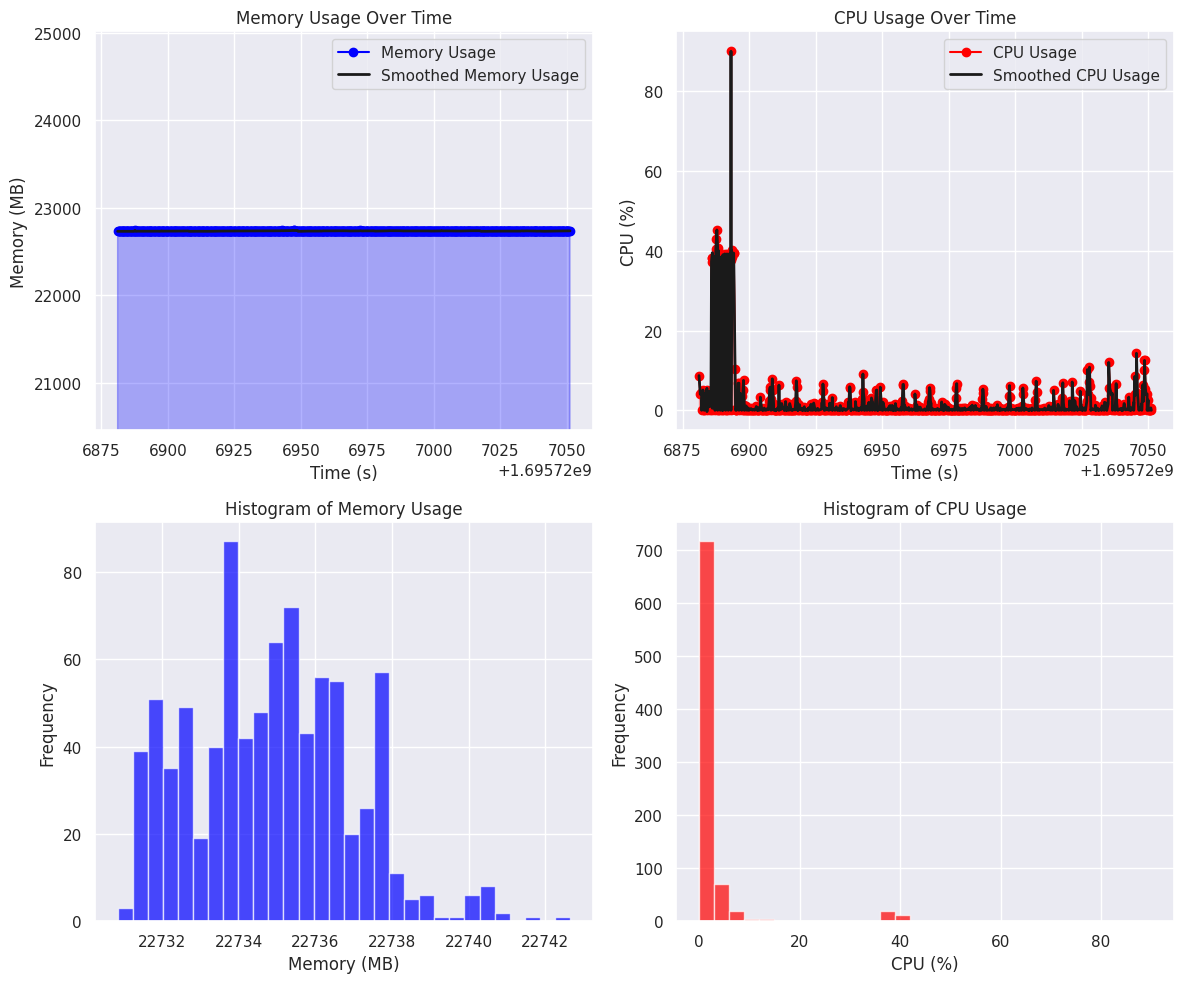

In [66]:
plot_resources()

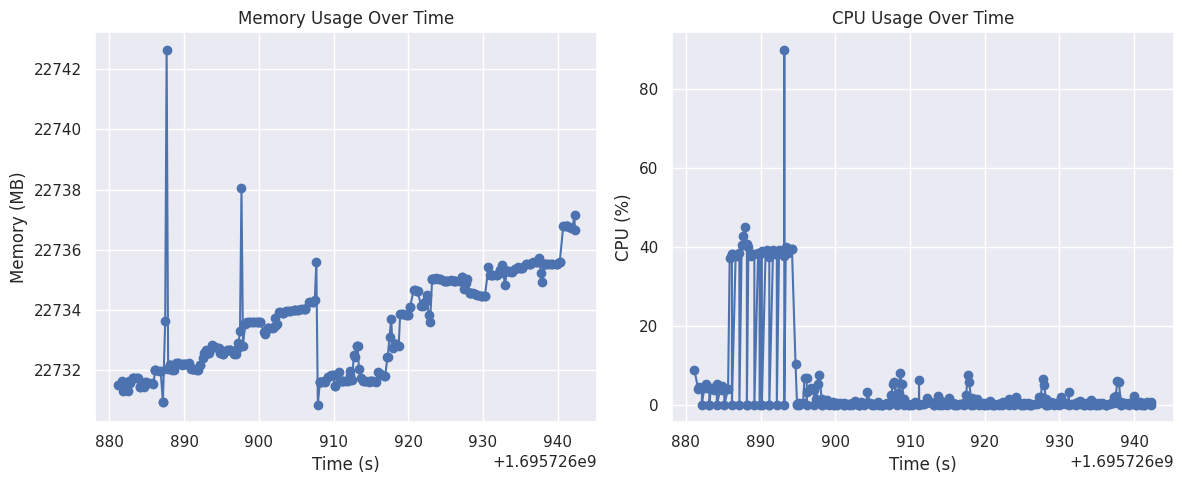

In [60]:
def plot_resources():
    """Plot the collected resource data."""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(time_data, memory_data, '-o')
    plt.title("Memory Usage Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Memory (MB)")
    
    plt.subplot(1, 2, 2)
    plt.plot(time_data, cpu_data, '-o')
    plt.title("CPU Usage Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("CPU (%)")
    
    plt.tight_layout()
    plt.show()
plot_resources()

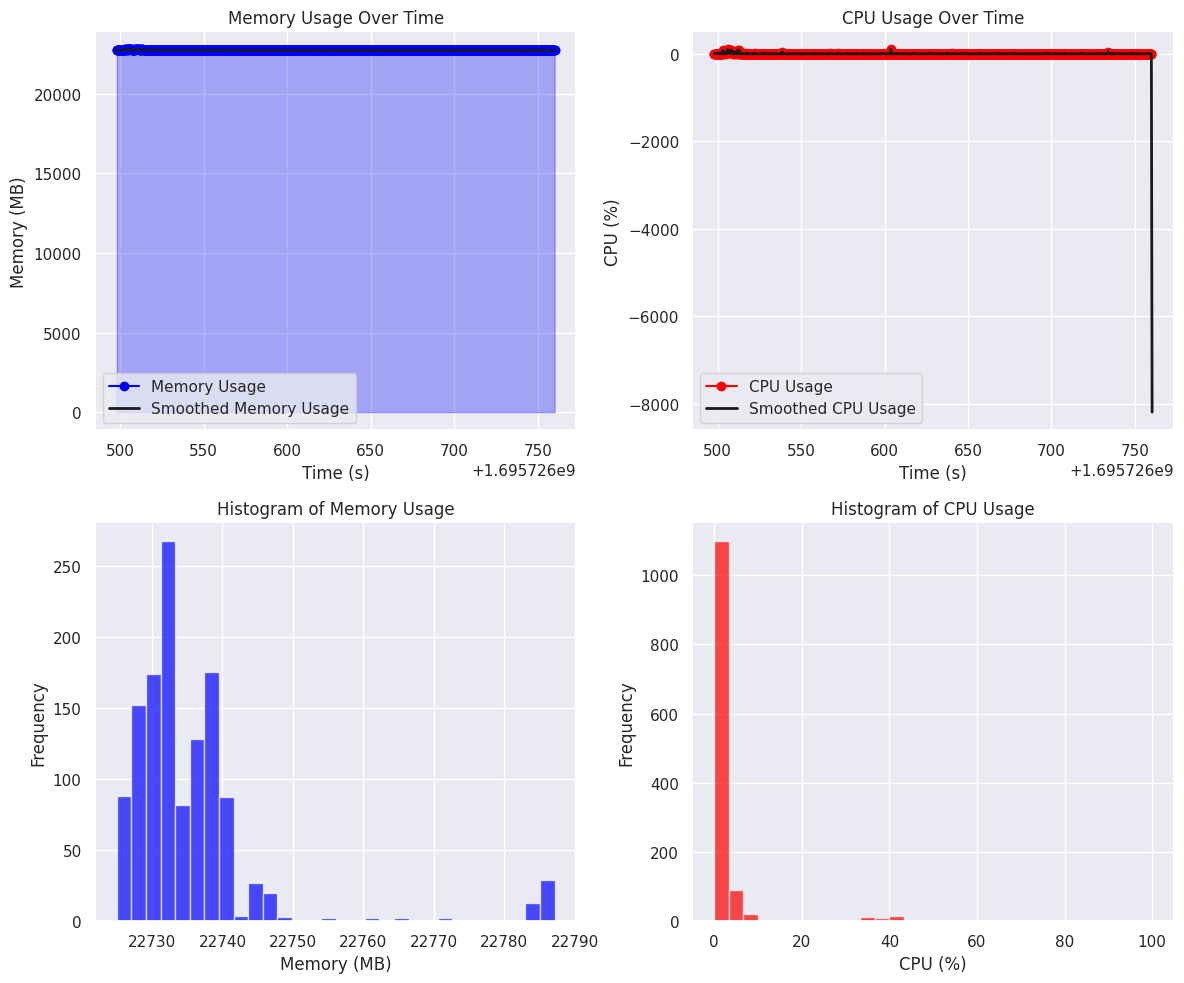

In [56]:
def plot_resources():
    """Plot the collected resource data."""
    plt.figure(figsize=(12, 10))
    
    # Memory Usage Over Time
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(time_data, memory_data, '-o', color="blue", label="Memory Usage")
    ax1.fill_between(time_data, 0, memory_data, color="blue", alpha=0.3)
    
    # Add smoothed spline for memory data
    spl_memory = UnivariateSpline(time_data, memory_data, s=100)  # The 's' parameter determines the amount of smoothing
    ax1.plot(time_data, spl_memory(time_data), 'k-', linewidth=2, label="Smoothed Memory Usage")
    
    ax1.set_title("Memory Usage Over Time")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Memory (MB)")
    ax1.legend()
    
    # CPU Usage Over Time
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(time_data, cpu_data, '-o', color="red", label="CPU Usage")
    ax2.fill_between(time_data, 0, cpu_data, color="red", alpha=0.3)
    
    # Add smoothed spline for CPU data
    spl_cpu = UnivariateSpline(time_data, cpu_data, s=10)  # The 's' parameter determines the amount of smoothing
    ax2.plot(time_data, spl_cpu(time_data), 'k-', linewidth=2, label="Smoothed CPU Usage")
    
    ax2.set_title("CPU Usage Over Time")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("CPU (%)")
    ax2.legend()
    
    # Histogram for Memory Usage
    ax3 = plt.subplot(2, 2, 3)
    ax3.hist(memory_data, bins=30, color="blue", alpha=0.7)
    ax3.set_title("Histogram of Memory Usage")
    ax3.set_xlabel("Memory (MB)")
    ax3.set_ylabel("Frequency")
    
    # Histogram for CPU Usage
    ax4 = plt.subplot(2, 2, 4)
    ax4.hist(cpu_data, bins=30, color="red", alpha=0.7)
    ax4.set_title("Histogram of CPU Usage")
    ax4.set_xlabel("CPU (%)")
    ax4.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

plot_resources()

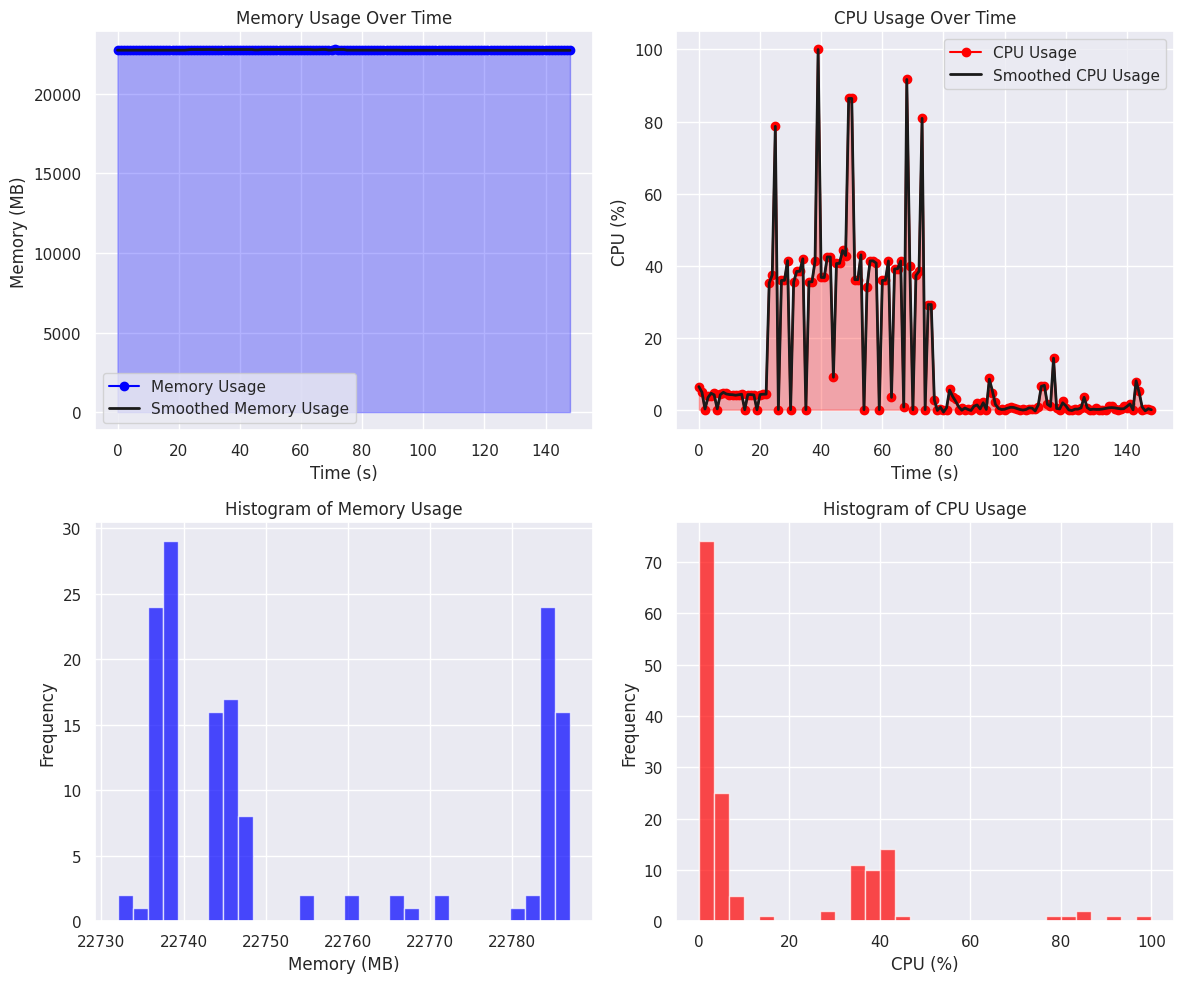

In [50]:
plot_resources()

In [ ]:
SGDpagerank(m, num_iterations=1000, mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, 
             full_batch_update_iters=1000, dip_window=5, plateau_iterations=5, sampling_method='probability_based')